In [12]:
import numpy as np
import pandas as pd
import glob, os
import itertools
import matplotlib.image as mpimg
import pickle
import math
import json
import csv
from functools import *
from sklearn.metrics import *
import pickle
import time
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

%matplotlib inline
import matplotlib.pyplot as plt

MAX_FRAME_NUM = 1000000

In [2]:
failure_starts = pd.read_csv('/mnt/ml-data4/tsd/val_mp4s.csv', header=None, index_col=0).sample(frac=1)
failure_starts.index = failure_starts.index.map(int)
failure_starts['start1'] = MAX_FRAME_NUM
failure_starts['start2'] = MAX_FRAME_NUM

selected_failure_starts = pd.read_csv('/mnt/ml-data4/tsd/failure_starts.csv', index_col=0, names=['start1', 'start2'])
selected_failure_starts.index = selected_failure_starts.index.map(int)
# selected_failure_starts['start1'] = selected_failure_starts['start1']*25/30 # account for the 25fps vs 30 fps bug in the code.
# selected_failure_starts['start2'] = selected_failure_starts['start2']*25/30 # account for the 25fps vs 30 fps bug in the code.
max_id = max(selected_failure_starts.index)
failure_starts = failure_starts[failure_starts.index <= max_id]
failure_starts = failure_starts[failure_starts.index >= 4572]
failure_starts.update(selected_failure_starts)
failure_starts.loc[failure_starts['start2'] < 0, 'start2'] = MAX_FRAME_NUM

vids = failure_starts.index.values.tolist()
failed_vids = failure_starts[failure_starts.start1 < MAX_FRAME_NUM].index.values
succeeded_vids = failure_starts[failure_starts.start1 >= MAX_FRAME_NUM].index.values
np.random.shuffle(failed_vids)
np.random.shuffle(succeeded_vids)


In [7]:
# baselione - prod performance. Precision: 0.21.  Recall - 0.45

def load_df_from_json(fn):
    if not os.path.isfile(fn):
        return pd.DataFrame()
    l = [ f['fields'] for f in json.load(open(fn, 'r')) if 'fields' in f]
    df = pd.DataFrame(l)
    return df

# def validate_ewm(fn):
#     df = load_df_from_json(fn)
#     if df.empty:
#         return
#     ser = ((df['ewm_mean'] - df['rolling_ewm'])[20:] > 1e-03)
#     return ser[ser].count() == 0

# for vid in alerted.index.values:
#     print(vid)
#     print(validate_ewm('/mnt/ml-data4/tsd/jsons/{}.json'.format(vid)))

def load_detections(vid):
    return load_df_from_json('/mnt/ml-data4/tsd/jsons/{}.json'.format(vid))

settings = dict(THRESHOLD_LOW=0.11, THRESHOLD_HIGH=0.65, INIT_SAFE_FRAME_NUM=30, ROLLING_MEAN_SHORT_MULTIPLE=5.43)

def is_failing(prediction, detective_sensitivity=1.0):
    if prediction.current_frame_num < settings['INIT_SAFE_FRAME_NUM']:
        return False

    adjusted_ewm_mean = prediction.ewm_mean * detective_sensitivity
    if adjusted_ewm_mean < settings['THRESHOLD_LOW'] + prediction.rolling_mean_long:
        return False

    if adjusted_ewm_mean > settings['THRESHOLD_HIGH'] + prediction.rolling_mean_long:
        return True

    if adjusted_ewm_mean > prediction.rolling_mean_short * settings['ROLLING_MEAN_SHORT_MULTIPLE']:
        return True
    
    return False

def detect_failure_start(vid, plot=False, **args):
    det = load_detections(vid)
    if plot:
        det[['current_p', 'ewm_mean', 'rolling_mean_short', 'rolling_mean_long']].plot()

    print(vid)
    det['is_failing'] = det.apply(is_failing, axis=1)
    failing_frames = det[det['is_failing']].index

    if len(failing_frames) > 0:
        return det[det['is_failing']].index[0]


In [27]:
raw_dets = []
for pkl in ['prod1.pkl', 'prod2.pkl', 'prod3.pkl', 'prod4.pkl', 'prod5.pkl', 'prod6.pkl', 'prod7.pkl', 'prod8.pkl', 'prod9.pkl', 'prod10.pkl']:
    raw_dets = raw_dets + pickle.load( open( "/mnt/ml-data4/error-analysis/tsd-val/6109_neg_32213_16800.out/"+pkl, "rb" ) )
#     raw_dets = raw_dets + pickle.load( open( "/mnt/ml-data4/error-analysis/tsd-val/neg_32213_22300.out/"+pkl, "rb" ) )

dets_map = dict()
for det in raw_dets:
    vid = int(det[0].split('-')[1].split('/')[-1])
    fid = int(det[0].split('-')[2].split('.')[0])
    dets_map.setdefault(vid, []).append([fid, det[1][0][1], det[1][1][1], det[1][2][1]])


In [4]:

def clip(x, lower):
    if x < lower:
        return 0
    return x

def pseudo_moving_avg(input, win_size):
    mean = 0
    output = []
    for j, i in enumerate(input):
        diff =  (i - mean )/float(win_size if win_size < j else j+1)
        mean = mean + diff
        output += [mean]
    
    return output

def load_detections(vid, thresh, ewm_span, rolling_win):

    df = pd.DataFrame(dets_map[vid], columns=['fid', 'p1', 'p2', 'p3'])
    df['accu_detection'] = df.p1.apply(clip, args=(thresh,)) + df.p2.apply(clip, args=(thresh,)) + df.p3.apply(clip, args=(thresh,))
    df['rolling_ewm'] = df.accu_detection.ewm(span=ewm_span).mean()
    avgs = np.array(pseudo_moving_avg(df.accu_detection, rolling_win))
    df['rolling_mean'] = pd.Series(avgs, index=np.arange(0, len(avgs)))
    return df.set_index('fid')


In [5]:
START1_RELAX = 2
START2_RELAX = 30

def eval_vids(vids_to_work_on, plot=False, **args):
    results = dict(p=[], fp=[], fn=[], tp=[], tn=[])
    for vid in vids_to_work_on:
        if plot:
            plt.figure()

        detected_failure_start = detect_failure_start(vid, plot=plot, **args)
#         detected_failure_start = detect_failure_start(vid, plot)
        if detected_failure_start == None:
            detected_failure_start = MAX_FRAME_NUM

        start1 = failure_starts.loc[int(vid)].start1
        start2 = failure_starts.loc[int(vid)].start2

        if (start1) < MAX_FRAME_NUM:
            results.get('p').append(vid)

        if detected_failure_start < start1 - START1_RELAX :
            result = 'fp'
        elif detected_failure_start > start2 + START2_RELAX:
            result = 'fn'
        elif detected_failure_start < MAX_FRAME_NUM:
            result = 'tp'
        else:
            result = 'tn'
        results.get(result).append(vid)

        if plot:
            if start1 < MAX_FRAME_NUM:
                plt.plot([start1, start1],[0,1], linestyle='-', color='y')
            if start2 < MAX_FRAME_NUM:
                plt.plot([start2, start2],[0,1], linestyle='-', color='r')
            if detected_failure_start < MAX_FRAME_NUM:
                plt.plot([detected_failure_start, detected_failure_start],[0,1], linestyle='-', color='b')
            plt.title(str(vid) + result)
    return results

# results = eval_vids(np.hstack((failed_videos.tail(30).index.values, succeeded_videos.tail(50).index.values)), False)
# results = eval_vids(np.hstack((failed_videos.head(20).index.values, succeeded_videos.head(50).index.values)))

# results = eval_vids(vids, rolling_win=460.0, v_thresh=2.4000000000000004, rolling_multiple=2.2, ewm_span=15.0, min_ewm=0.65, thresh=0.06)


# rolling avg based prediction.

Precision: 0.15 Recall: 0.29 based on production params (except long term rolling avg)


In [38]:

def truncated(x, lower, upper):
    if x < lower:
        return -math.inf
    if x > upper:
        return math.inf
    return x

def detect_failure_start(vid, thresh, v_thresh, min_ewm, ewm_span, rolling_win, rolling_multiple, plot=False):
    df = load_detections(vid, thresh, ewm_span, rolling_win)
    df['rolling_mean'] = df['rolling_mean'] * rolling_multiple
    detected_failures = df.index[df.rolling_ewm.apply(truncated, args=(min_ewm, v_thresh)) > df.rolling_mean]
    if plot:
        plt.figure()
        df[['rolling_ewm','rolling_mean']].plot()

#     if len(detected_failures[detected_failures > 30]) > 0:
#         return detected_failures[detected_failures > 30].min()
    if len(detected_failures) > 0:
        return detected_failures.min()

# results = eval_vids(vids, rolling_win=460.0, v_thresh=2.4000000000000004, rolling_multiple=2.2, ewm_span=15.0, min_ewm=0.65, thresh=0.06)
results = eval_vids(vids, rolling_win=460.0, v_thresh=2.4000000000000004, rolling_multiple=2.8, ewm_span=15.0, min_ewm=0.58, thresh=0.1)
precision = len(results['tp'])/(len(results['fp'])+len(results['tp']))
recall = len(results['tp'])/(len(results['p']))
f1 = 2*(precision*recall)/(precision+recall)
f0_5 = (1+0.25)*(precision*recall)/(0.25*precision+recall)
print("Failure detection on test videos: F1: %0.2f - F0.5: %0.2f - Precision: %0.2f - Recall: %0.2f" % (f1, f0_5, precision, recall))
print("FP: {} - FN: {} - TP: {} - P: {}".format(len(results['fp']), len(results['fn']), len(results['tp']), len(results['p'])))


Failure detection on test videos: F1: 0.25 - F0.5: 0.36 - Precision: 0.52 - Recall: 0.16
FP: 30 - FN: 52 - TP: 32 - P: 198


In [28]:
kkk = set(results['fp'])
kkk.update(set(results1['fp']))
list(kkk)
# with open('/tmp/fp.csv', 'w') as f:
#     for item in kkk:
#         f.write("{:08d}\n".format(item))

[5250,
 10499,
 10115,
 11141,
 10760,
 5644,
 11150,
 6031,
 6158,
 6034,
 5011,
 10133,
 5015,
 5016,
 5145,
 5275,
 6172,
 5021,
 10398,
 10273,
 5794,
 10152,
 5801,
 5546,
 5036,
 11182,
 5936,
 4914,
 6324,
 5046,
 10422,
 10936,
 11062,
 5942,
 11319,
 4924,
 10684,
 5693,
 10303,
 10177,
 11202,
 4677,
 6085,
 5447,
 5319,
 5577,
 5706,
 6347,
 10186,
 10957,
 5456,
 10706,
 10451,
 10588,
 5987,
 11108,
 5737,
 6125,
 11117,
 5231,
 10224,
 11246,
 4847,
 11250,
 5876,
 6132,
 5623,
 11000,
 4987]

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


{'fn': [5145],
 'fp': [5021,
  5231,
  5250,
  5546,
  5577,
  5623,
  5644,
  5706,
  5737,
  5794,
  5801,
  5876,
  5987,
  6031,
  6034,
  6125,
  6324,
  6347,
  10177,
  10224,
  10398,
  10451,
  10499,
  10760,
  10957,
  11141,
  11150,
  11182],
 'p': [5145, 6125, 10115],
 'tn': [4677,
  4847,
  4914,
  4924,
  4987,
  5011,
  5015,
  5016,
  5036,
  5046,
  5275,
  5319,
  5447,
  5456,
  5693,
  5936,
  5942,
  6085,
  6132,
  6158,
  6172,
  10115,
  10133,
  10152,
  10186,
  10273,
  10303,
  10422,
  10588,
  10684,
  10706,
  10936,
  11000,
  11062,
  11108,
  11117,
  11202,
  11246,
  11250,
  11319],
 'tp': []}

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

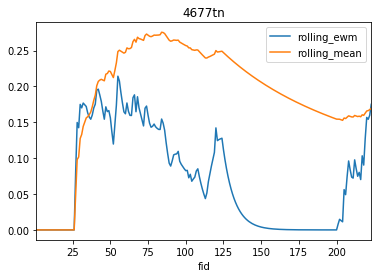

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

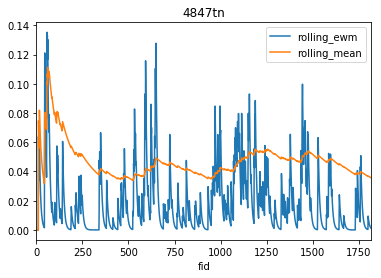

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

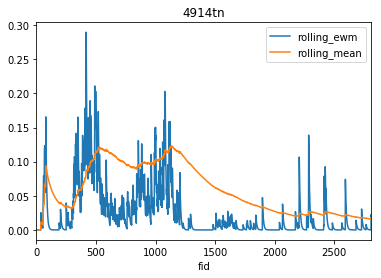

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

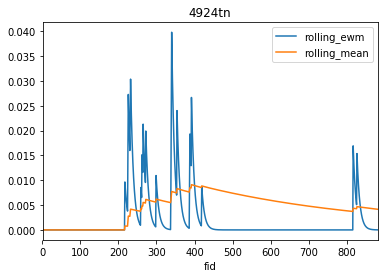

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

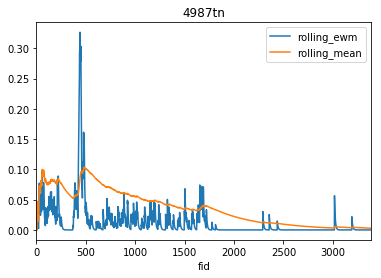

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

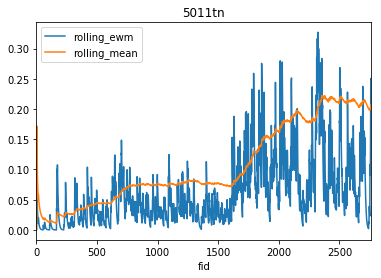

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

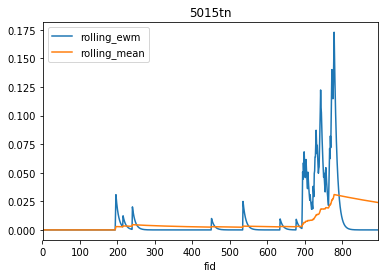

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

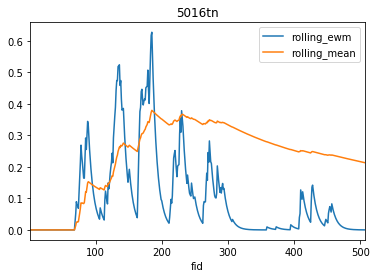

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

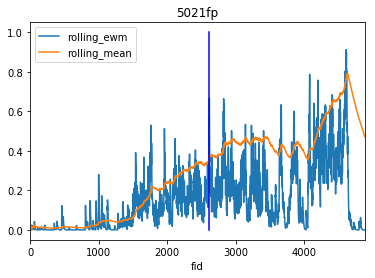

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

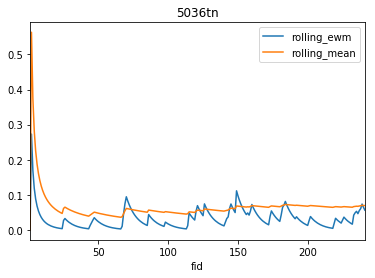

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

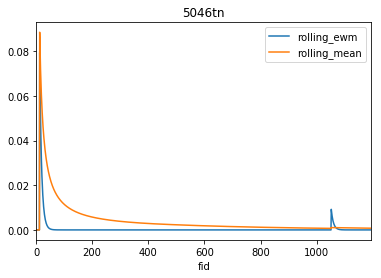

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

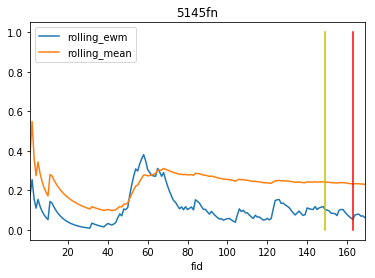

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

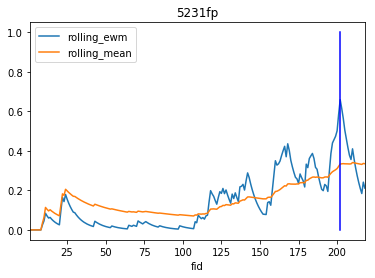

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

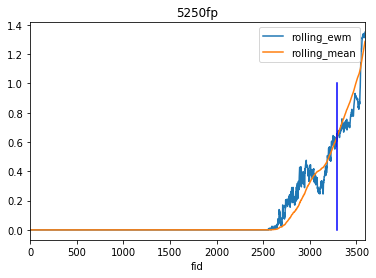

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

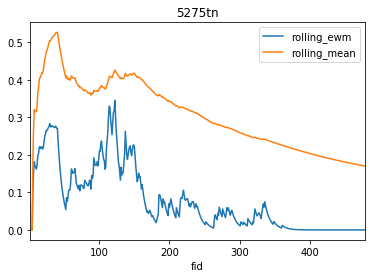

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

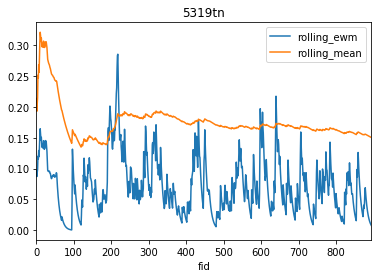

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

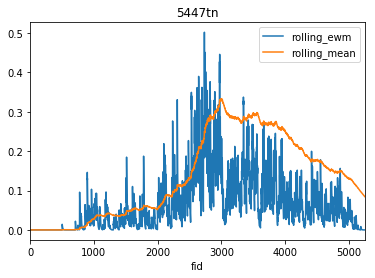

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

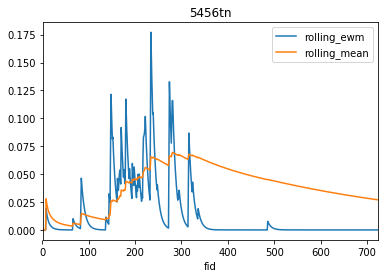

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

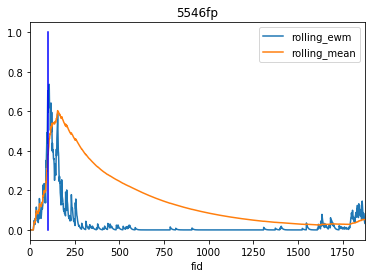

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

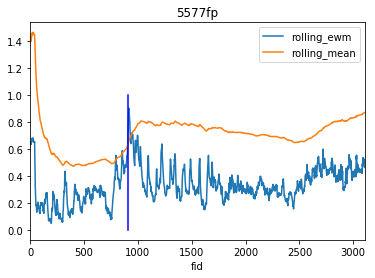

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

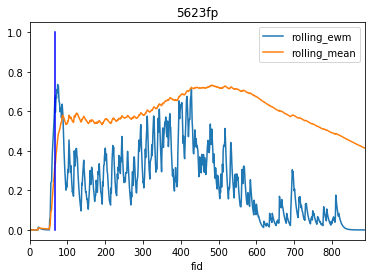

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

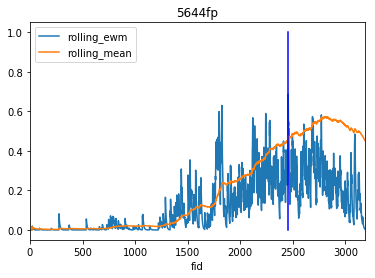

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

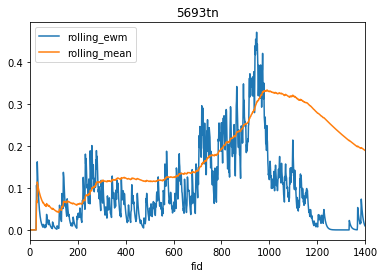

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

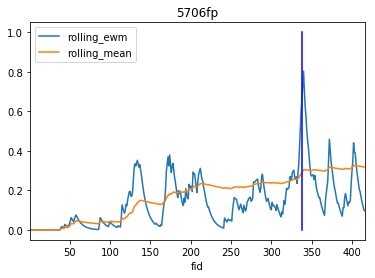

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

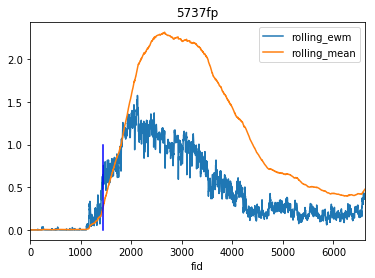

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

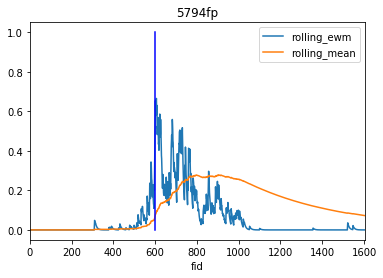

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

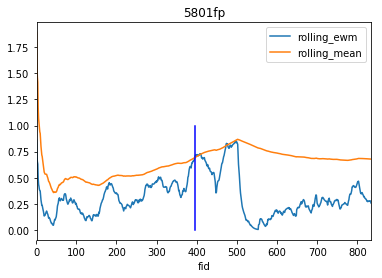

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

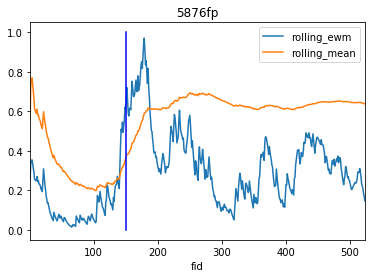

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

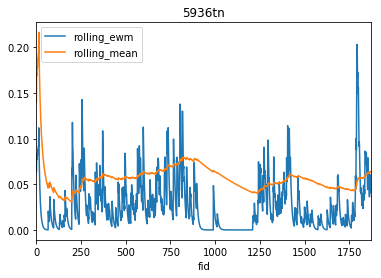

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

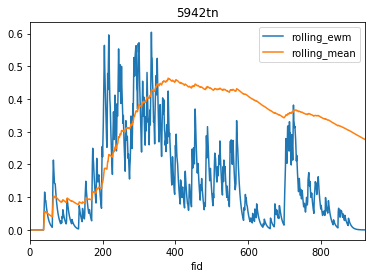

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

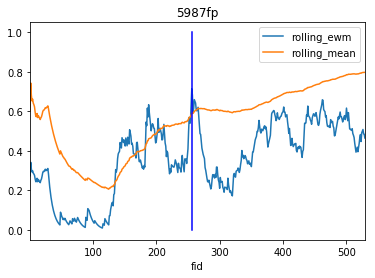

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

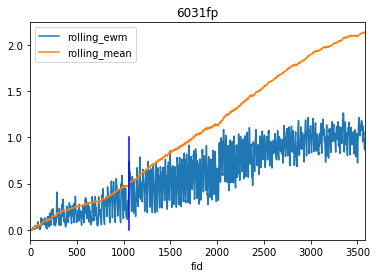

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

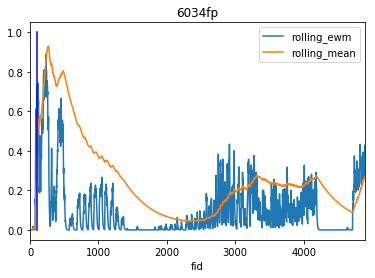

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

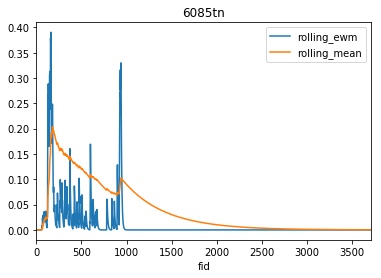

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

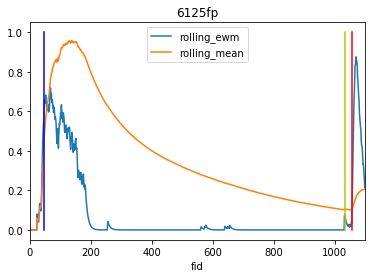

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

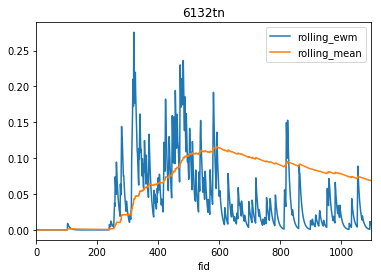

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

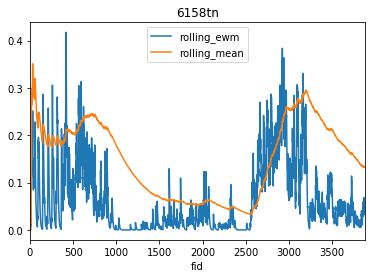

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

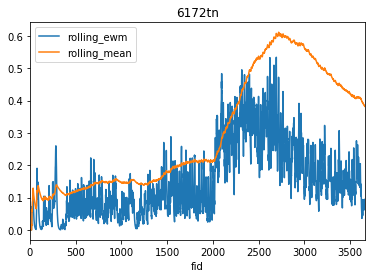

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

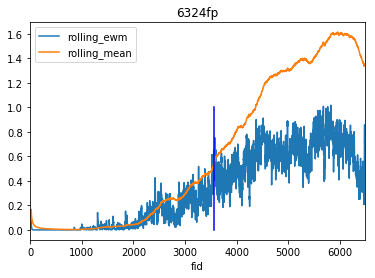

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

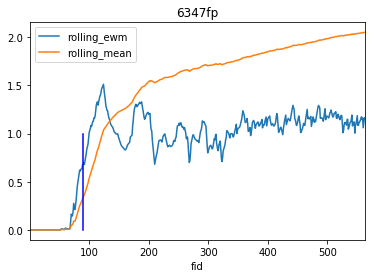

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

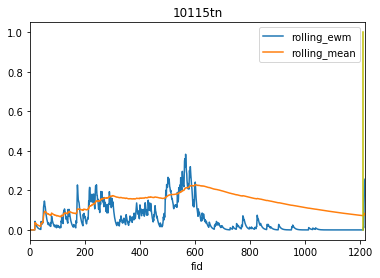

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

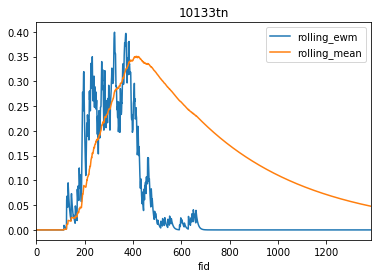

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

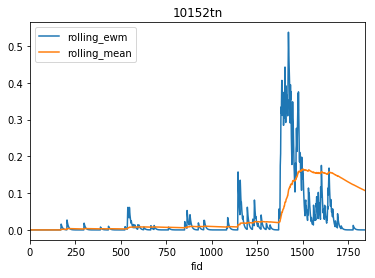

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

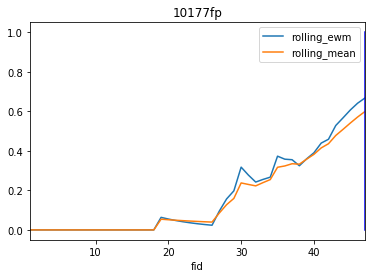

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

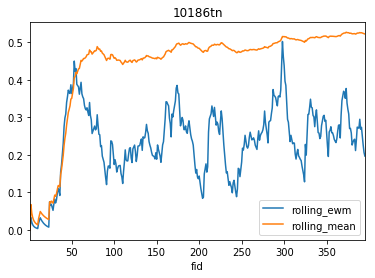

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

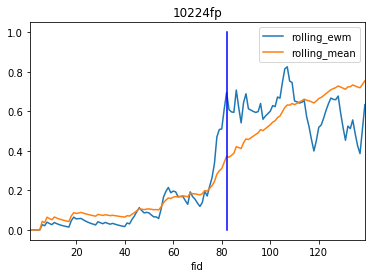

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

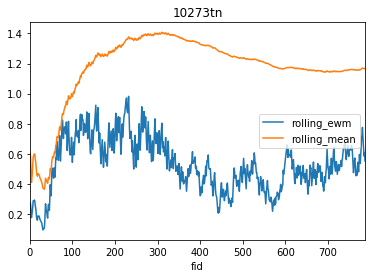

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

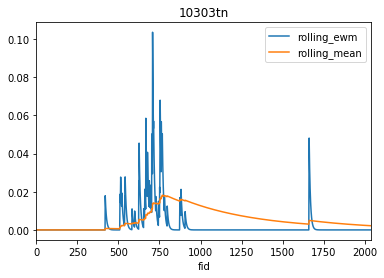

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

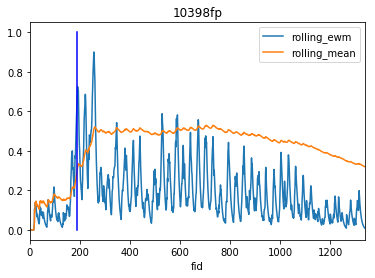

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

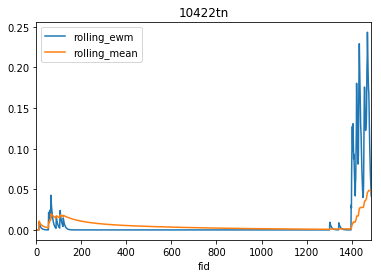

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

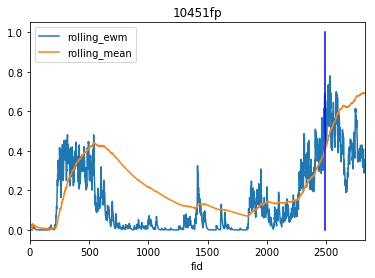

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

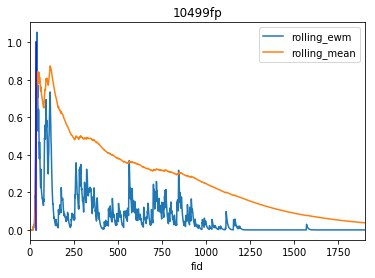

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

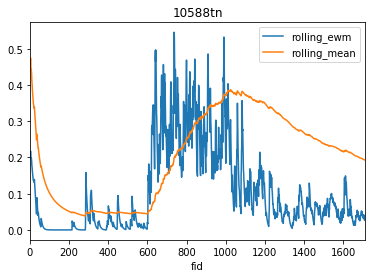

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

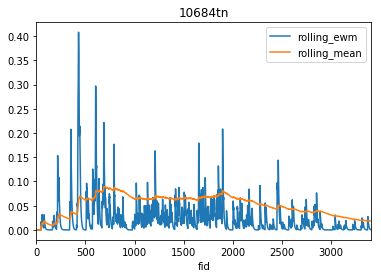

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

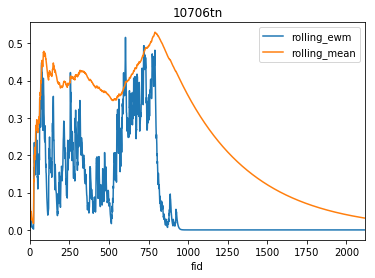

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

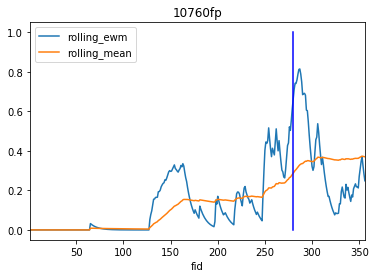

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

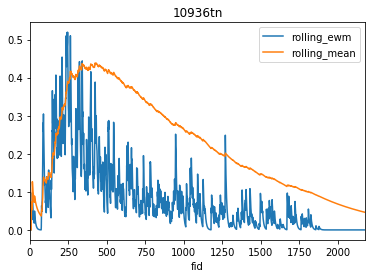

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

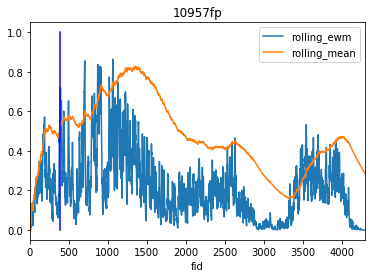

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

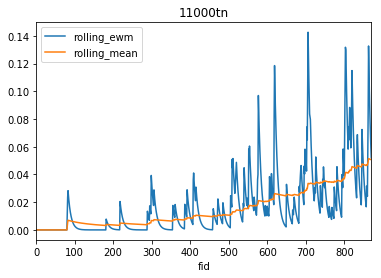

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

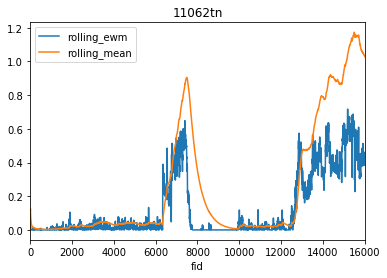

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

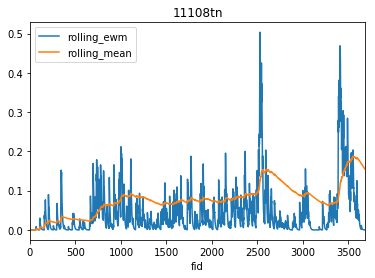

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

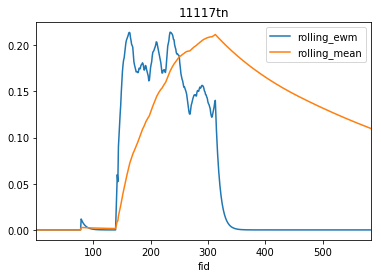

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

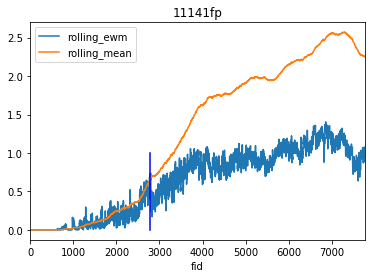

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

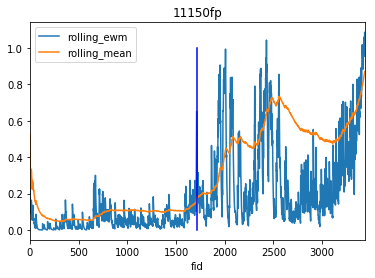

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

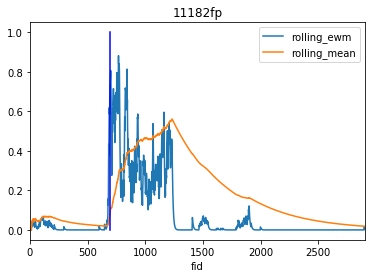

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

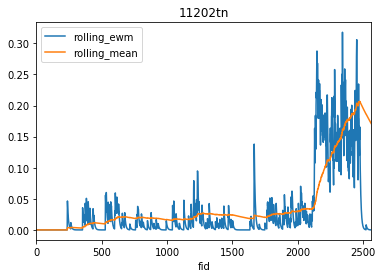

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

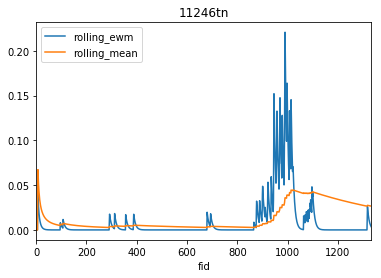

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

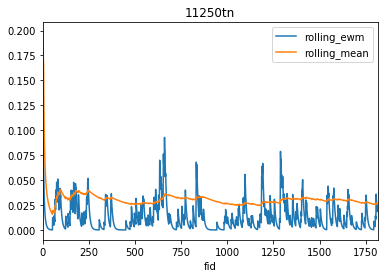

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

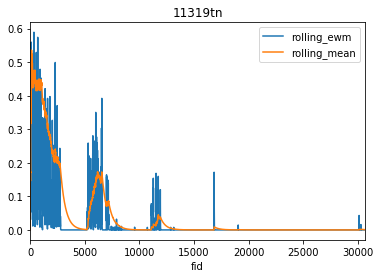

In [21]:
eval_vids(sorted(list(kkk)), rolling_win=460.0, v_thresh=2.4000000000000004, rolling_multiple=2.2, ewm_span=15.0, min_ewm=0.65, thresh=0.06, plot=True)


{'fn': [],
 'fp': [4677,
  4847,
  4914,
  4924,
  4987,
  5011,
  5015,
  5016,
  5021,
  5036,
  5046,
  5145,
  5250,
  5275,
  5319,
  5447,
  5456,
  5693,
  5706,
  5737,
  5794,
  5876,
  5936,
  5942,
  6031,
  6034,
  6085,
  6132,
  6158,
  6172,
  6324,
  6347,
  10115,
  10133,
  10152,
  10186,
  10273,
  10303,
  10422,
  10499,
  10588,
  10684,
  10706,
  10760,
  10936,
  10957,
  11000,
  11062,
  11108,
  11117,
  11141,
  11150,
  11182,
  11202,
  11246,
  11250,
  11319],
 'p': [5145, 6125, 10115],
 'tn': [5231, 5546, 5577, 5623, 5644, 5801, 5987, 10177, 10224, 10398, 10451],
 'tp': [6125]}

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

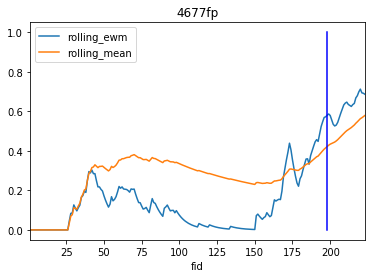

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

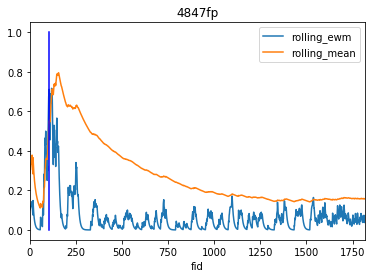

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

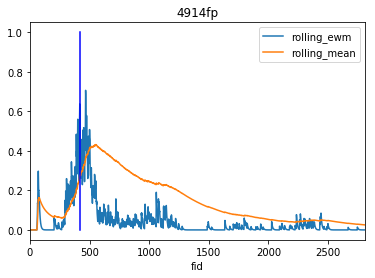

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

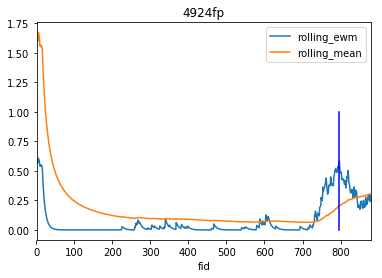

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

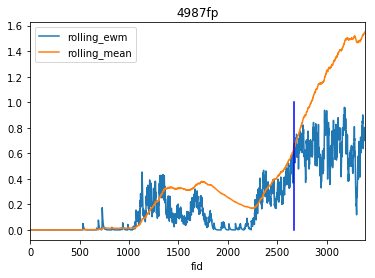

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

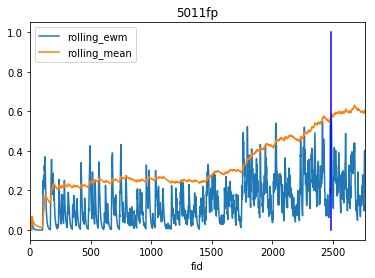

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

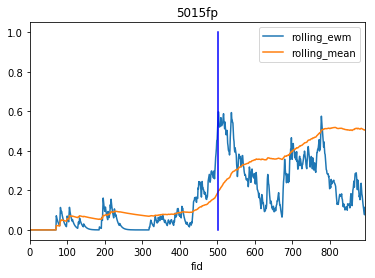

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

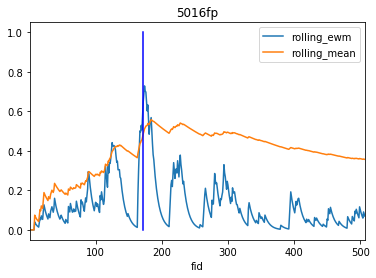

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

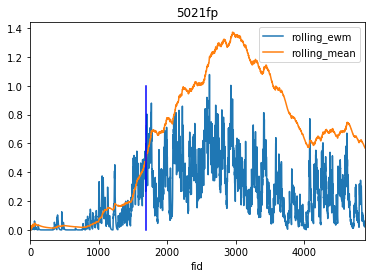

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

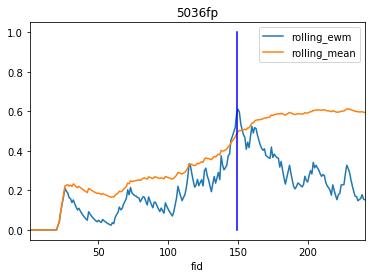

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

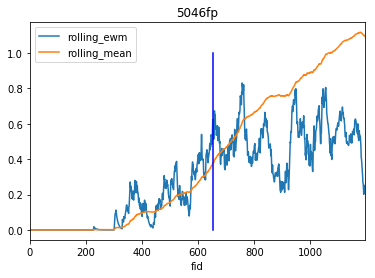

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

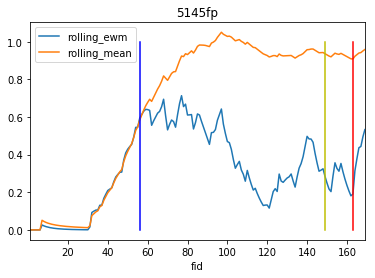

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

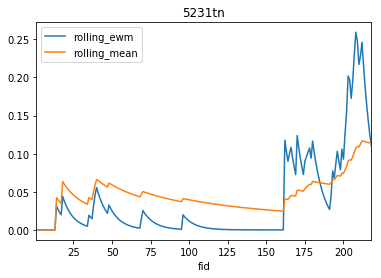

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

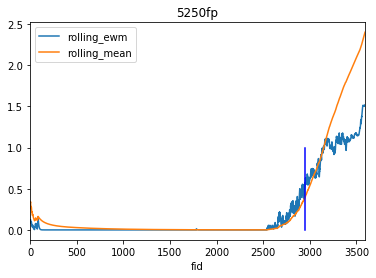

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

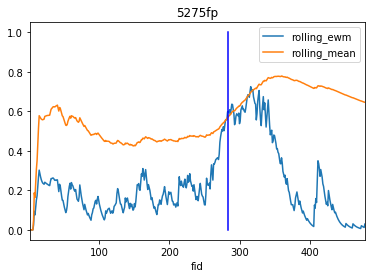

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

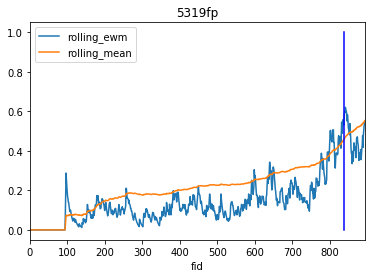

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

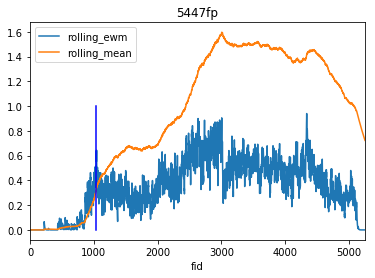

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

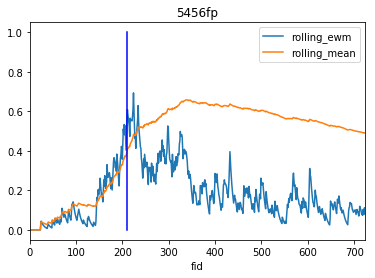

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

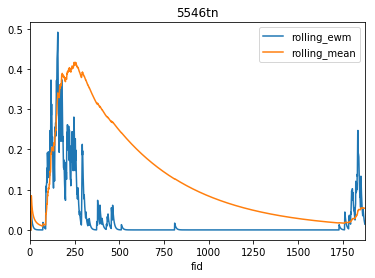

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

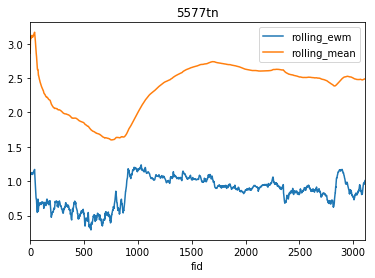

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

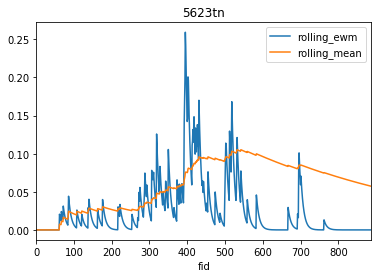

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

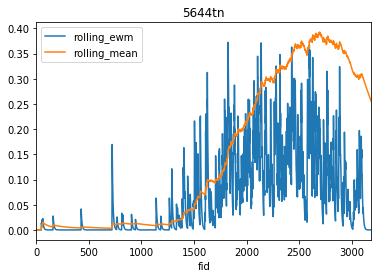

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

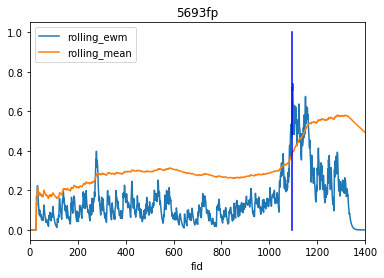

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

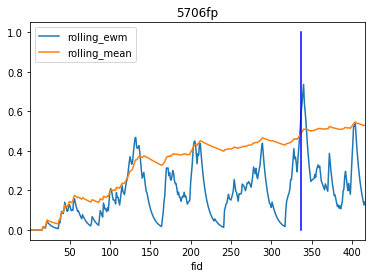

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

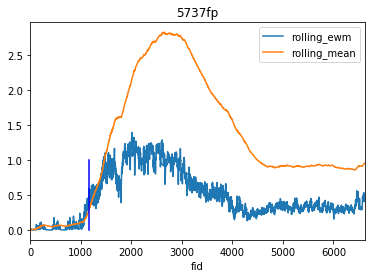

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

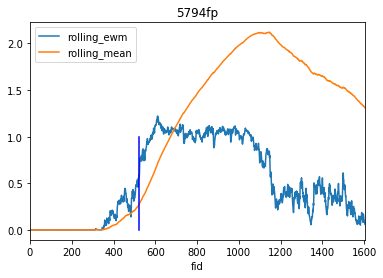

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

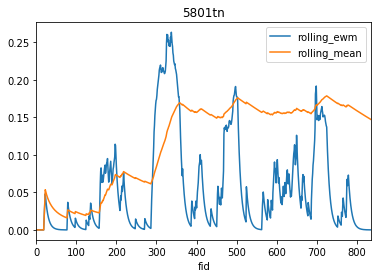

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

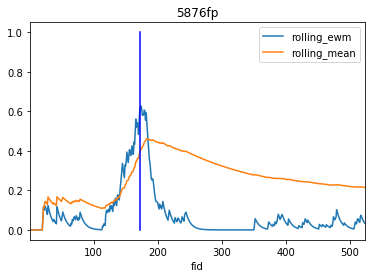

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

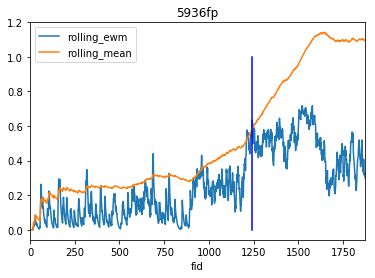

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

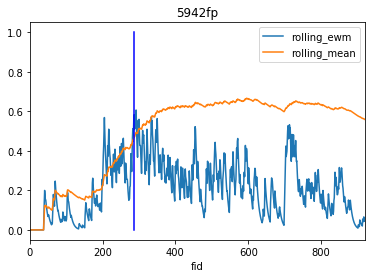

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

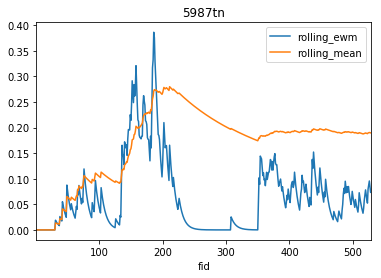

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

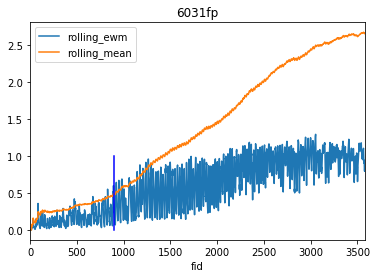

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

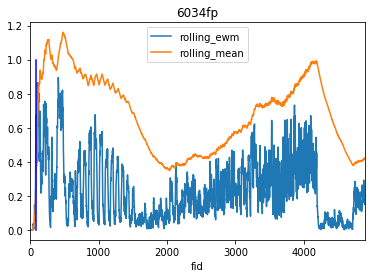

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

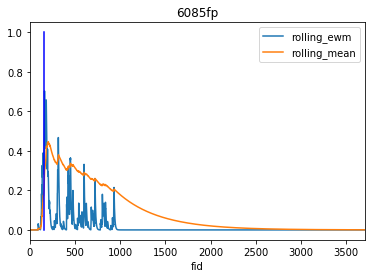

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

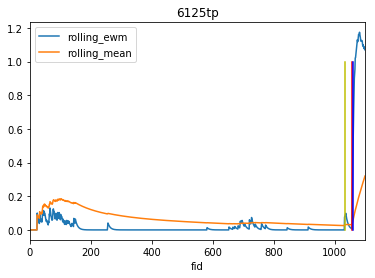

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

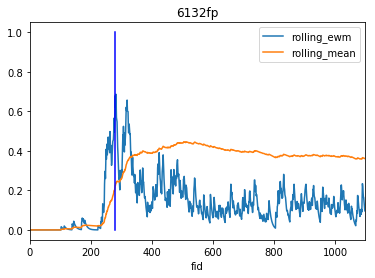

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

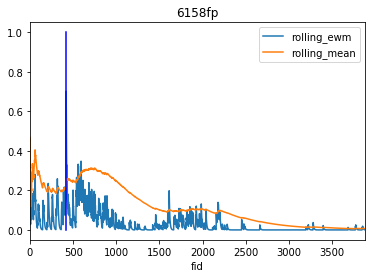

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

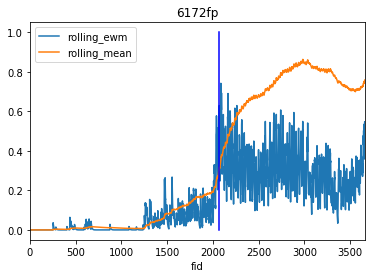

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

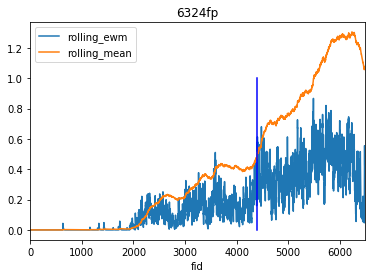

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

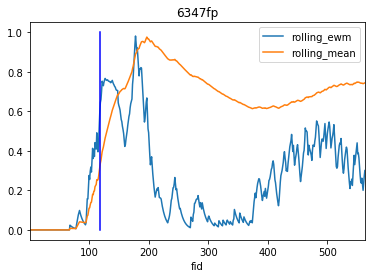

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

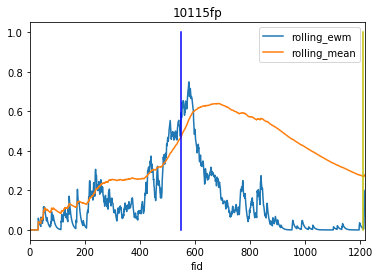

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

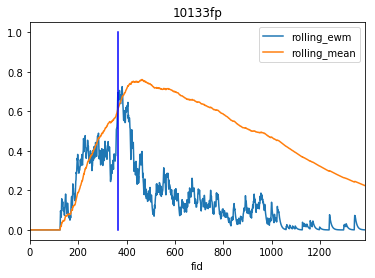

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

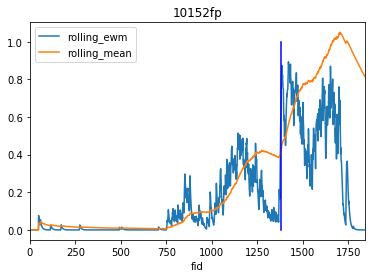

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

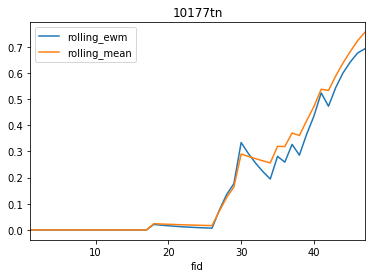

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

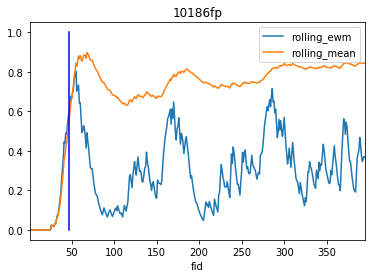

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

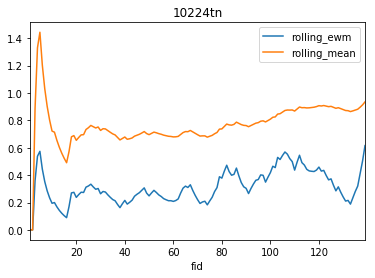

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

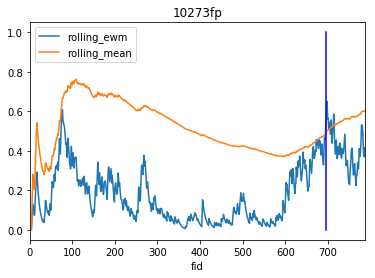

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

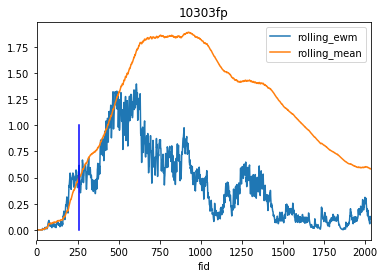

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

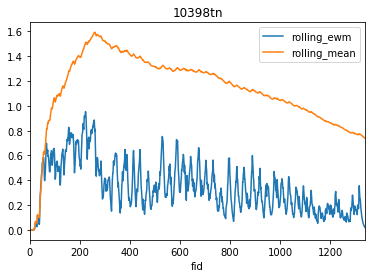

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

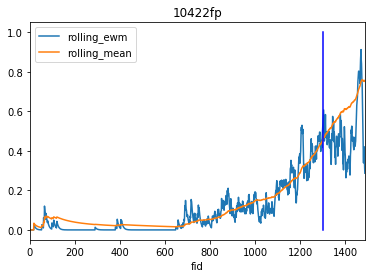

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

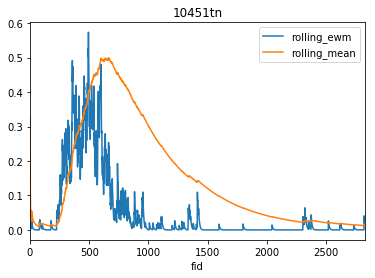

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

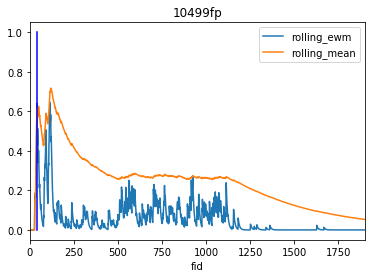

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

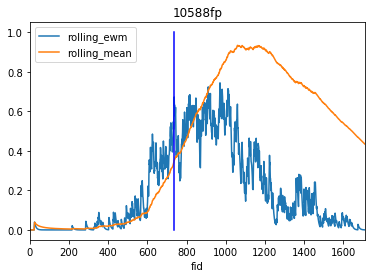

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

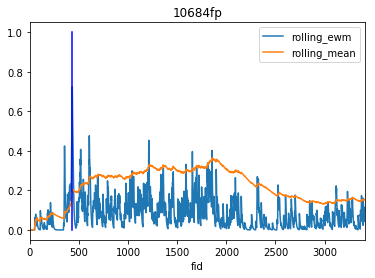

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

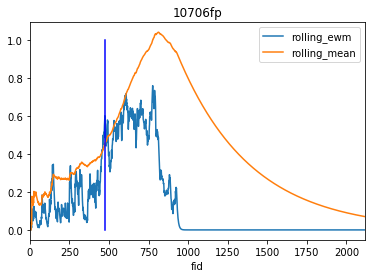

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

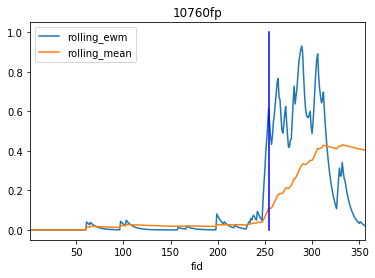

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

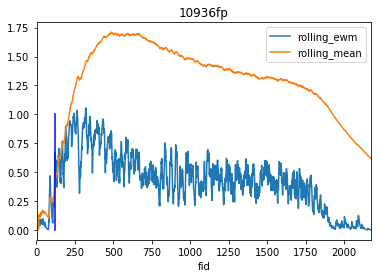

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

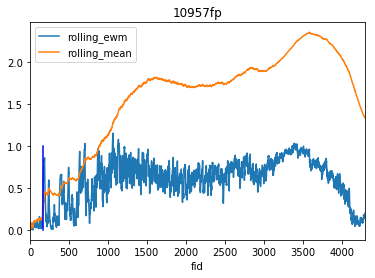

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

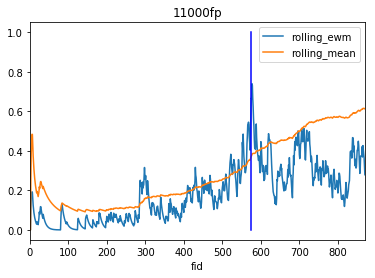

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

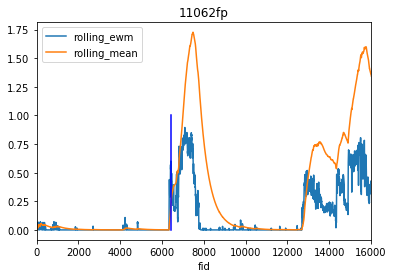

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

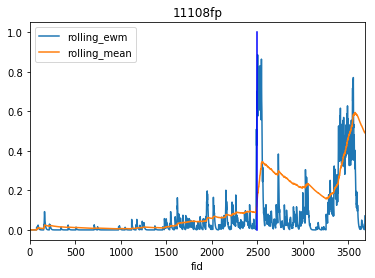

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

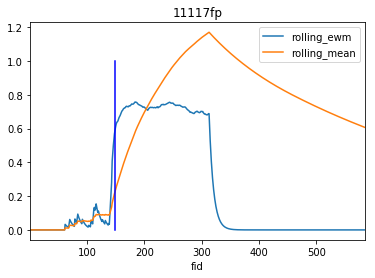

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

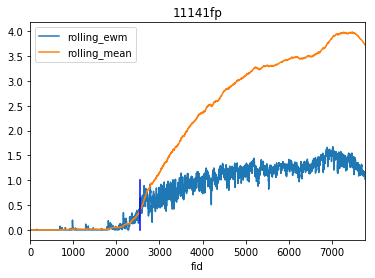

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

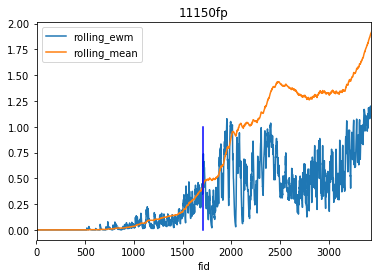

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

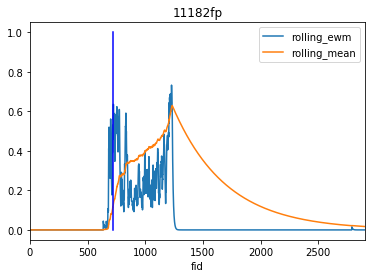

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

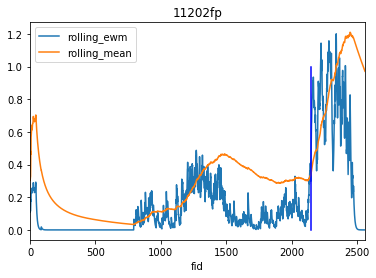

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

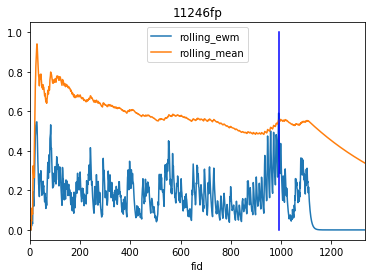

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

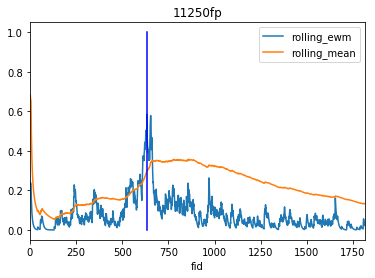

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

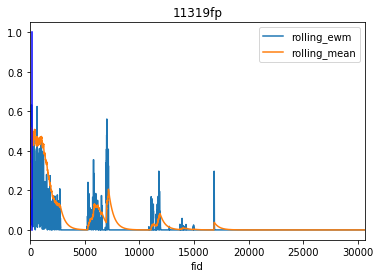

In [29]:

eval_vids(sorted(list(kkk)), rolling_win=460.0, v_thresh=2.4000000000000004, rolling_multiple=2.8, ewm_span=15.0, min_ewm=0.58, thresh=0.1, plot=True)


In [7]:
dets_map1 = dets_map
results1 = results

/Users/kenneth/.pyenv/versions/3.5.6/lib/python3.5/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


p1        p2        p3  accu_detection  rolling_ewm  \
p1              1.000000  0.895916  0.822431        0.952582     0.870958   
p2              0.895916  1.000000  0.948300        0.978189     0.912959   
p3              0.822431  0.948300  1.000000        0.942671     0.892591   
accu_detection  0.952582  0.978189  0.942671        1.000000     0.926580   
rolling_ewm     0.870958  0.912959  0.892591        0.926580     1.000000   
rolling_mean    0.814215  0.864300  0.850368        0.873002     0.966614   
boxes           0.373015  0.220128  0.159379        0.280727     0.104210   
boxes_10        0.260200  0.143006  0.089029        0.181658     0.182023   
r               0.359084  0.248362  0.201399        0.280911     0.254186   
has_failed      0.559904  0.524632  0.509607        0.551089     0.601049   

                rolling_mean     boxes  boxes_10         r  has_failed  
p1                  0.814215  0.373015  0.260200  0.359084    0.559904  
p2                  0.864300  0.220128  0.143006  0.248362    0.524632  
p3                  0.850368  0.159379  0.089029  0.201399    0.509607  
accu_detection      0.873002  0.280727  0.181658  0.280911    0.551089  
rolling_ewm         0.966614  0.104210  0.182023  0.254186    0.601049  
rolling_mean        1.000000  0.019633  0.053221  0.170096    0.594483  
boxes               0.019633  1.000000  0.485456  0.331508    0.141357  
boxes_10            0.053221  0.485456  1.000000  0.411920    0.255208  
r                   0.170096  0.331508  0.411920  1.000000    0.264149  
has_failed          0.594483  0.141357  0.255208  0.264149    1.000000

<Figure size 432x288 with 0 Axes>

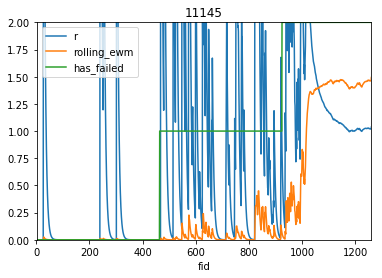

<Figure size 432x288 with 0 Axes>

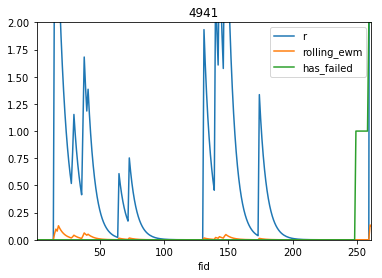

<Figure size 432x288 with 0 Axes>

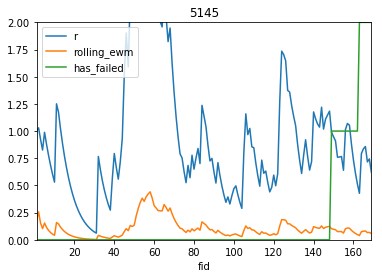

<Figure size 432x288 with 0 Axes>

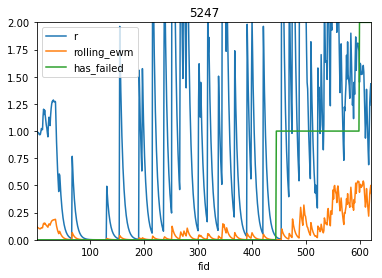

<Figure size 432x288 with 0 Axes>

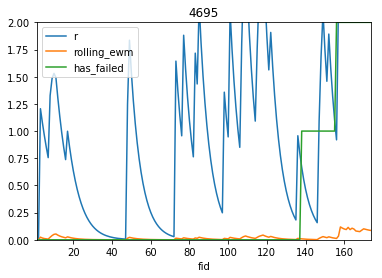

<Figure size 432x288 with 0 Axes>

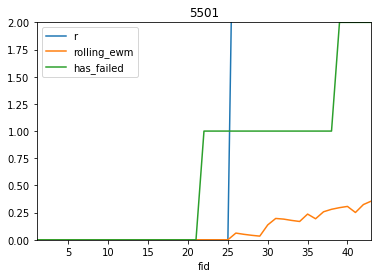

<Figure size 432x288 with 0 Axes>

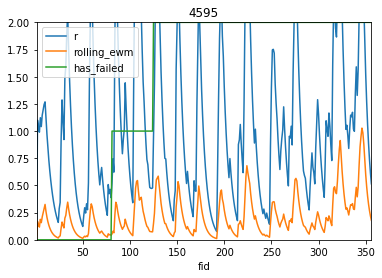

<Figure size 432x288 with 0 Axes>

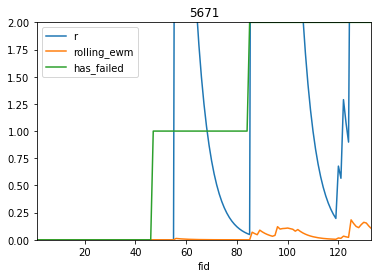

<Figure size 432x288 with 0 Axes>

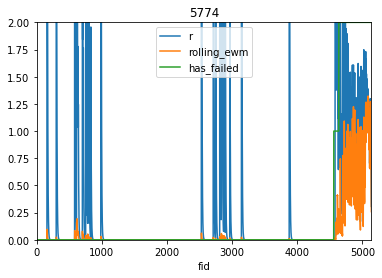

<Figure size 432x288 with 0 Axes>

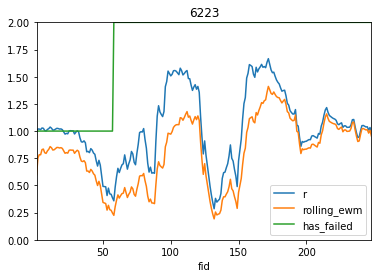

<Figure size 432x288 with 0 Axes>

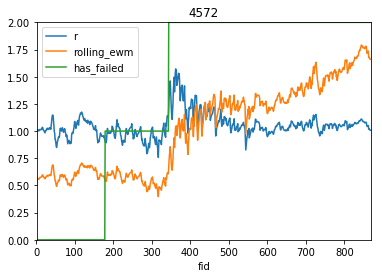

<Figure size 432x288 with 0 Axes>

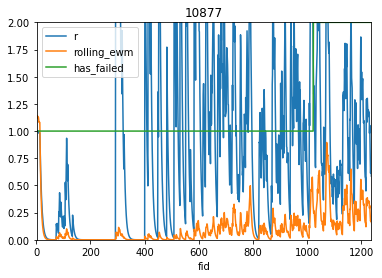

<Figure size 432x288 with 0 Axes>

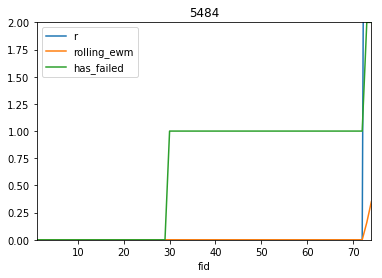

<Figure size 432x288 with 0 Axes>

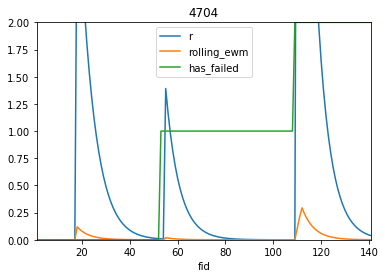

<Figure size 432x288 with 0 Axes>

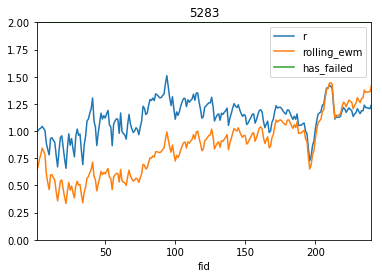

<Figure size 432x288 with 0 Axes>

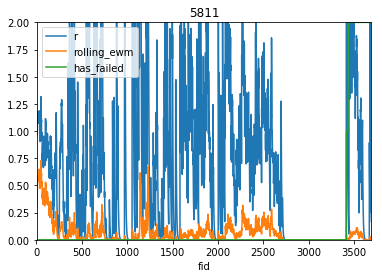

<Figure size 432x288 with 0 Axes>

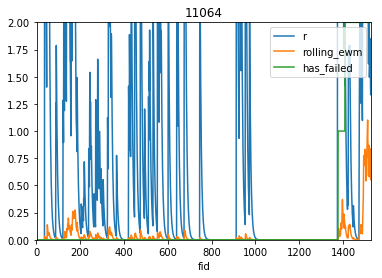

<Figure size 432x288 with 0 Axes>

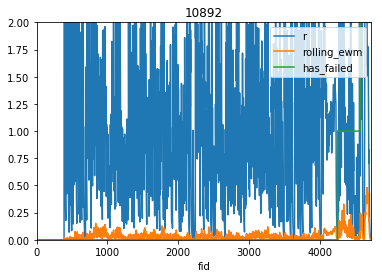

<Figure size 432x288 with 0 Axes>

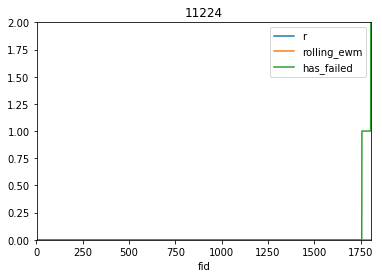

<Figure size 432x288 with 0 Axes>

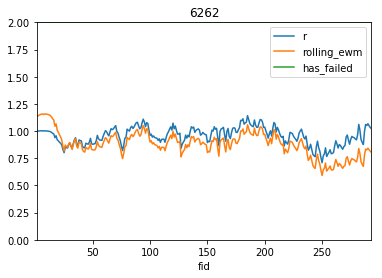

<Figure size 432x288 with 0 Axes>

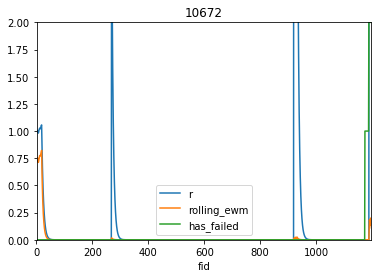

<Figure size 432x288 with 0 Axes>

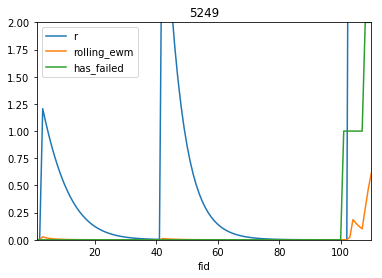

<Figure size 432x288 with 0 Axes>

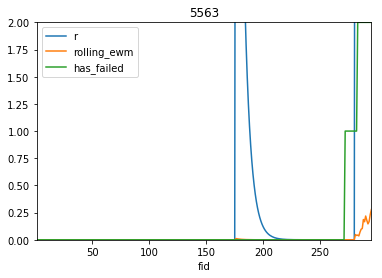

<Figure size 432x288 with 0 Axes>

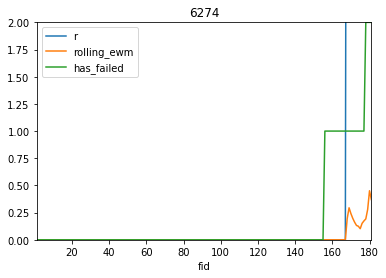

<Figure size 432x288 with 0 Axes>

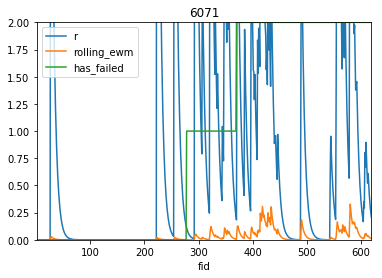

<Figure size 432x288 with 0 Axes>

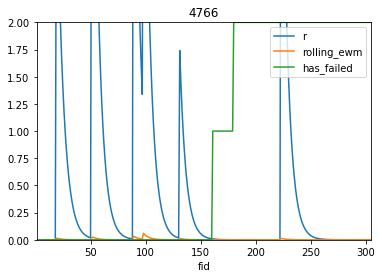

<Figure size 432x288 with 0 Axes>

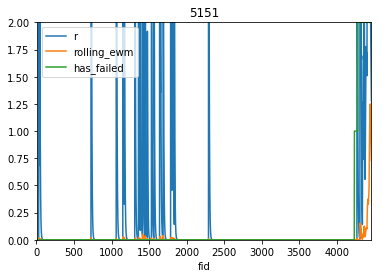

<Figure size 432x288 with 0 Axes>

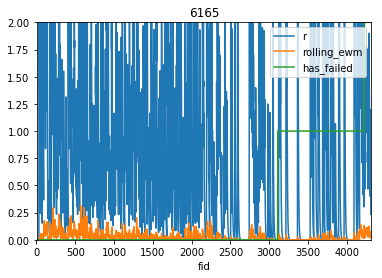

<Figure size 432x288 with 0 Axes>

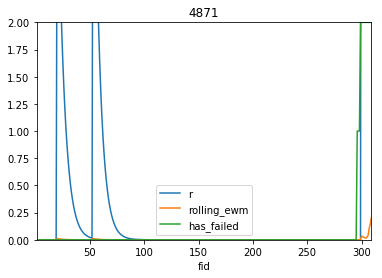

<Figure size 432x288 with 0 Axes>

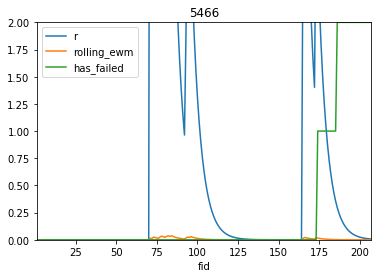

<Figure size 432x288 with 0 Axes>

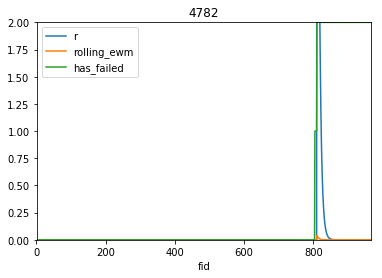

<Figure size 432x288 with 0 Axes>

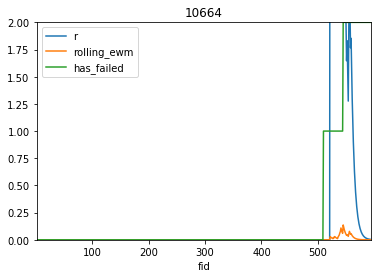

<Figure size 432x288 with 0 Axes>

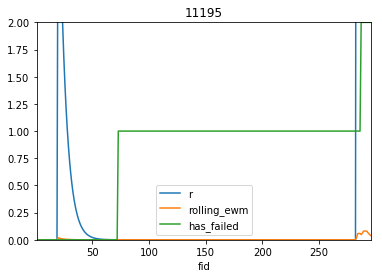

<Figure size 432x288 with 0 Axes>

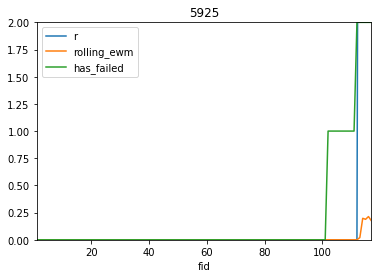

<Figure size 432x288 with 0 Axes>

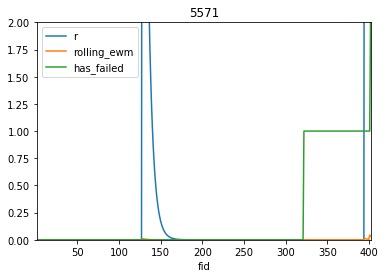

<Figure size 432x288 with 0 Axes>

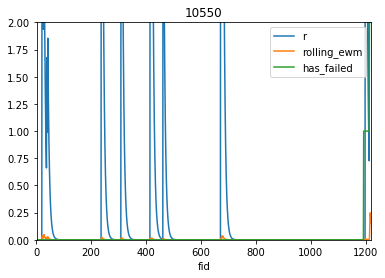

<Figure size 432x288 with 0 Axes>

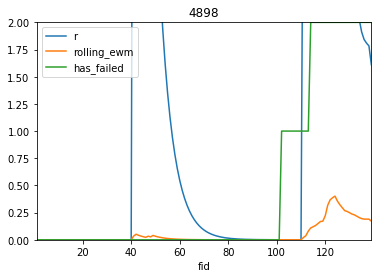

<Figure size 432x288 with 0 Axes>

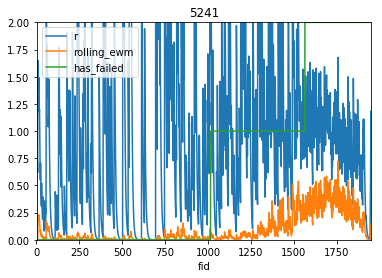

<Figure size 432x288 with 0 Axes>

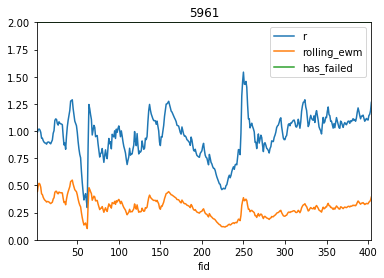

In [27]:
def get_df(vid):
    df = load_detections(vid, rolling_win=50.0, ewm_span=10.0, thresh=0.06)

    start1 = int(failure_starts.loc[vid].start1)
    start2 = int(failure_starts.loc[vid].start2)

    if start2 >= MAX_FRAME_NUM:
        start2 = len(df)
    
    df['boxes'] = ((df['p1'] - df['rolling_mean']) > 0.16)*1 + ((df['p2'] - df['rolling_mean']) > 0.16)*1 + ((df['p3'] - df['rolling_mean']) > 0.16)*1 
    df['boxes_10'] = df.boxes.rolling(10).sum()
    df['boxes_10'].fillna(0)
    df['r'] = (df['rolling_ewm']/(df['rolling_mean'].clip(0.0001))).clip(0,30)

    df['has_failed'] = 0
    # give a bit of leeway for start1 since it is a very conservative point
#     start1 = start1 + (start2 - start1)//5
    df.loc[start1:, 'has_failed'] = 1
    df.loc[start2:, 'has_failed'] = 2

    plt.figure()
    ax = df[['r', 'rolling_ewm', 'has_failed']].plot()
    ax.set_ylim(0,2)
    plt.title(str(vid))

#     return pd.concat([df.loc[max(0, start1-10):start1+10], df.loc[max(0, start2-10):start2+10]])
    return df

df = pd.concat(map(get_df, results['fn']))
df.corr()

# Rolling avg based prediction with *warning* and *error* level

In [106]:

def eval_vids_2_level(vids_to_work_on, plot=False, **args):
    results = dict(p=[], fp=[], fn=[], tp=[], tn=[], fp05=[])
    for vid in vids_to_work_on:
        if plot:
            plt.figure()

        (detected_warning_start, detected_failure_start) = detect_failure_start(vid, plot=plot, **args)
        if detected_warning_start == None:
            detected_warning_start = MAX_FRAME_NUM
        if detected_failure_start == None:
            detected_failure_start = MAX_FRAME_NUM

        start1 = failure_starts.loc[int(vid)].start1
        start2 = failure_starts.loc[int(vid)].start2

        if (start1) < MAX_FRAME_NUM:
            results.get('p').append(vid)

        if detected_failure_start > start2 + START2_RELAX and detected_warning_start > start2 + START2_RELAX:
            result = 'fn'
        elif detected_failure_start < start1 - START1_RELAX:
            result = 'fp'
        elif detected_warning_start < start1 - START1_RELAX:
            result = 'fp05'
        elif detected_warning_start < MAX_FRAME_NUM or detected_failure_start < MAX_FRAME_NUM:
            result = 'tp'
        else:
            result = 'tn'
        results.get(result).append(vid)

        if plot:
            if start1 < MAX_FRAME_NUM:
                plt.plot([start1, start1],[0,1], linestyle='-', color='y')
            if start2 < MAX_FRAME_NUM:
                plt.plot([start2, start2],[0,1], linestyle='-', color='r')
            if detected_failure_start < MAX_FRAME_NUM:
                plt.plot([detected_failure_start, detected_failure_start],[0,1], linestyle='-', color='b')
            plt.title(str(vid) + result)
    return results

def detect_failure_start(vid, thresh, v_thresh, min_ewm, ewm_span, rolling_win, rolling_multiple, ewm_factor, multiple_factor, plot=False):
    df = load_detections(vid, thresh, ewm_span, rolling_win)
    df['rolling_mean'] = df['rolling_mean'] * rolling_multiple
    detected_warning = df.index[df.rolling_ewm.apply(truncated, args=(min_ewm, v_thresh)) > df.rolling_mean]
    detected_failures = df.index[df.rolling_ewm.apply(truncated, args=(min_ewm*ewm_factor, v_thresh*ewm_factor)) > df.rolling_mean*multiple_factor]
    if plot:
        plt.figure()
        df[['rolling_ewm','rolling_mean']].plot()

    warning_start = None
    failure_start = None
    if len(detected_warning[detected_warning > 30]) > 0:
        warning_start = detected_warning[detected_warning > 30].min()
    if len(detected_failures[detected_failures > 30]) > 0:
        failure_start = detected_failures[detected_failures > 30].min()
    
    return (warning_start, failure_start)

# results = eval_vids_2_level(vids, rolling_win=460.0, v_thresh=1.4000000000000004, rolling_multiple=1.5, ewm_span=15.0, min_ewm=0.45, thresh=0.06, ewm_factor=2, multiple_factor=2)
results = eval_vids_2_level(vids, ewm_factor=2.0, rolling_multiple=2.2, min_ewm=0.4, multiple_factor=2.6000000000000005, v_thresh=2.4000000000000004, ewm_span=12.0,thresh=0.22, rolling_win=300.0)
precision = len(results['tp'])/(len(results['fp'])+len(results['fp05'])*0.2+len(results['tp']))
recall = len(results['tp'])/(len(results['p']))
f1 = 2*(precision*recall)/(precision+recall)
f0_5 = (1+0.25)*(precision*recall)/(0.25*precision+recall)
print("Failure detection on test videos: F1: %0.2f - F0.5: %0.2f - Precision: %0.2f - Recall: %0.2f" % (f1, f0_5, precision, recall))
print("FP: {} - FP05: {} - FN: {} - TP: {} - P: {}".format(len(results['fp']), len(results['fp05']), len(results['fn']), len(results['tp']), len(results['p'])))


Failure detection on test videos: F1: 0.45 - F0.5: 0.60 - Precision: 0.77 - Recall: 0.32
FP: 3 - FP05: 78 - FN: 32 - TP: 63 - P: 196


In [30]:
def objective(x):
    print(x)
    hyper_vids = np.hstack((np.random.choice(failed_vids, size=40), np.random.choice(succeeded_vids, size=200)))
    eval_res = eval_vids_2_level(hyper_vids, plot=False, **x) #, **dict( rolling_win=460.0, v_thresh=2.4000000000000004, rolling_multiple=2.2, ewm_span=15.0, min_ewm=0.65, thresh=0.06))
    eval_res['precision'] = len(eval_res['tp'])/max(1, len(eval_res['fp'])+len(eval_res['fp05'])*0.2+len(eval_res['tp']))
    eval_res['recall'] = len(eval_res['tp'])/(len(eval_res['p']))
    eval_res['f1'] = 2*(eval_res['precision']*eval_res['recall'])/max(eval_res['precision']+eval_res['recall'], 0.01)
    eval_res['f0.5'] = (1+0.25)*(eval_res['precision']*eval_res['recall'])/max(0.25*eval_res['precision']+eval_res['recall'], 0.01)
    loss = 1 - eval_res['f0.5']
    print(loss)
    return {
        'loss': loss,
        'status': STATUS_OK,
        # -- store other results like this
        'eval_time': time.time(),
        'results': results,
        }

trials = Trials()

space = {
    'thresh': hp.quniform('thresh', 0.05, 0.3, 0.02),
    'v_thresh': hp.quniform('v_thresh', 1.5, 3, 0.1),
    'min_ewm': hp.quniform('min_ewm', 0.1, 0.8, 0.05),
    'ewm_span': hp.quniform('ewm_span', 2, 50, 1),
    'rolling_win': hp.quniform('rolling_win', 50, 500, 10),
    'rolling_multiple': hp.quniform('rolling_multiple', 1, 10, 0.2),
    'ewm_factor': hp.quniform('ewm_factor', 1, 5, 0.2),
    'multiple_factor': hp.quniform('multiple_factor', 1, 5, 0.2)
}
best = fmin(objective,
    space=space,
    algo=tpe.suggest,
    max_evals=2000,
    trials=trials)

{'ewm_span': 44.0, 'min_ewm': 0.35000000000000003, 'v_thresh': 4.4, 'rolling_win': 310.0, 'ewm_factor': 1.2000000000000002, 'rolling_multiple': 9.200000000000001, 'thresh': 0.46, 'multiple_factor': 4.2}
  0%|          | 0/2000 [00:00<?, ?it/s, best loss: ?]


NameError: name 'eval_vids_2_level' is not defined

# Baseline. Simple prediction 

In [25]:
def detect_failure_start(vid, plot=False):
    df = load_detections(vid, thresh = 0.16, ewm_span = 9, rolling_win = 50)
    if len(df[df.accu_detection > 0.85]) > 5:
        return df[df.accu_detection > 0.85].index[4]

training_vids = np.hstack((failed_vids[:100], succeeded_vids[:1300]))
val_vids = np.hstack((failed_vids[100:], succeeded_vids[1300:]))

results = eval_vids(val_vids)
precision = len(results['tp'])/(len(results['fp'])+len(results['tp']))
recall = len(results['tp'])/(len(results['p']))
f1 = 2*(precision*recall)/(precision+recall)
f0_5 = (1+0.25)*(precision*recall)/(0.25*precision+recall)
print("Failure detection on test videos: F1: %0.2f - F0.5: %0.2f - Precision: %0.2f - Recall: %0.2f" % (f1, f0_5, precision, recall))
print("FP: {} - FN: {} - TP: {} - P: {}".format(len(results['fp']), len(results['fn']), len(results['tp']), len(results['p'])))


Failure detection on test videos: F1: 0.37 - F0.5: 0.41 - Precision: 0.44 - Recall: 0.32
FP: 40 - FN: 18 - TP: 31 - P: 96


# Random Forest

`failure_point` is mid point between `start1` and `start2`

Feature selection

In [78]:
# feature_list = ['p1', 'p2', 'p3', 'accu_detection', 'rolling_ewm', 'rolling_mean']
feature_list = ['p1', 'p2', 'rolling_meaning']

def load_as_xy(vid, thresh = 0.16, ewm_span = 9, rolling_win = 50, rolling_multiple = 5.43):
    df = load_detections(vid, thresh, ewm_span, rolling_win)
    df['r'] = (df['rolling_ewm']/df['rolling_mean'].clip(0.0001)).clip(0,30)
    start1 = int(failure_starts.loc[vid].start1)
    start2 = int(failure_starts.loc[vid].start2)
    if start2 >= MAX_FRAME_NUM:
        start2 = len(df)
    
    x = df[feature_list].to_numpy()
    
    y = np.zeros((len(df), 1))
    failure_point = start1 + (start2-start1)//2

    y[failure_point:] = 1
    return np.concatenate([y, x], axis=1)

def detect_failure_start(vid, plot=False):
    x = load_as_xy(vid, plot)
    y = model.predict(x[:,1:]) 
    if len(np.nonzero(y)[0]) > 0:
        if plot:
            for fr in np.nonzero(y)[0]:
                plt.plot([fr, fr],[0,1], linestyle='-', color='y')
        return np.nonzero(y)[0][0]

training_vids = np.hstack((failed_vids[:100], succeeded_vids[:1300]))
val_vids = np.hstack((failed_vids[100:], succeeded_vids[1300:]))

training_ds = np.vstack([load_as_xy(vid, False) for vid in training_vids])
np.random.shuffle(training_ds)
val_ds = np.vstack([load_as_xy(vid, False) for vid in val_vids])


1. p2 - (0.483466)
2. rolling_ewm - (0.447792)
3. p1 - (0.068742)


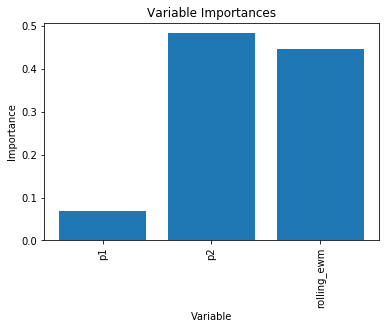

In [79]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state = 42, n_estimators=7, max_depth=2)
model.fit(training_ds[:,1:],training_ds[:,0])

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
for f in range(training_ds[:,1:].shape[1]):
    print("%d. %s - (%f)" % (f + 1, feature_list[indices[f]], importances[indices[f]]))

# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

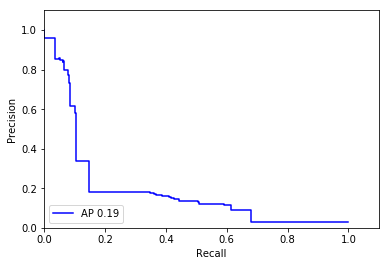

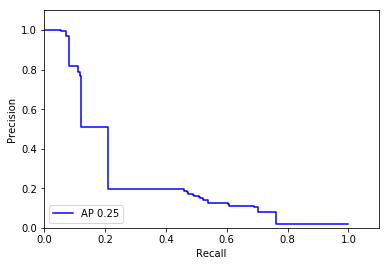

In [80]:
y = model.predict_proba(training_ds[:,1:])  
precision, recall, _ = precision_recall_curve(training_ds[:,0], y[:,1])
plt.step(recall, precision, color='b',
         where='post', label='AP %0.2f' % average_precision_score(training_ds[:,0], y[:,1]))
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.show()

y = model.predict_proba(val_ds[:,1:])  
precision, recall, _ = precision_recall_curve(val_ds[:,0], y[:,1])
plt.step(recall, precision, color='b',
         where='post', label='AP %0.2f' % average_precision_score(val_ds[:,0], y[:,1]))
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.show()

In [81]:
results = eval_vids(training_vids)
precision = len(results['tp'])/(len(results['fp'])+len(results['tp']))
recall = len(results['tp'])/(len(results['p']))
f1 = 2*(precision*recall)/(precision+recall)
f0_5 = (1+0.25)*(precision*recall)/(0.25*precision+recall)
print("Failure detection on test videos: F1: %0.2f - F0.5: %0.2f - Precision: %0.2f - Recall: %0.2f" % (f1, f0_5, precision, recall))
print("FP: {} - FN: {} - TP: {} - P: {}".format(len(results['fp']), len(results['fn']), len(results['tp']), len(results['p'])))

results = eval_vids(val_vids)
precision = len(results['tp'])/(len(results['fp'])+len(results['tp']))
recall = len(results['tp'])/(len(results['p']))
f1 = 2*(precision*recall)/(precision+recall)
f0_5 = (1+0.25)*(precision*recall)/(0.25*precision+recall)
print("Failure detection on test videos: F1: %0.2f - F0.5: %0.2f - Precision: %0.2f - Recall: %0.2f" % (f1, f0_5, precision, recall))
print("FP: {} - FN: {} - TP: {} - P: {}".format(len(results['fp']), len(results['fn']), len(results['tp']), len(results['p'])))


Failure detection on test videos: F1: 0.09 - F0.5: 0.17 - Precision: 0.42 - Recall: 0.05
FP: 7 - FN: 32 - TP: 5 - P: 100
Failure detection on test videos: F1: 0.04 - F0.5: 0.09 - Precision: 0.50 - Recall: 0.02
FP: 2 - FN: 35 - TP: 2 - P: 96


In [61]:
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = model.estimators_[5]

export_graphviz(tree, out_file = '/tmp/tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('/tmp/tree.dot')
# Write graph to a png file
graph.write_png('/tmp/tree.png')

# Logistic Regression

It underfits, even with a lot more features than Random Forest. 

In [160]:

def load_detections(vid, thresh, ewm_span, rolling_win):

    df = pd.DataFrame(dets_map[vid], columns=['fid', 'p1', 'p2', 'p3'])
    df['accu_detection'] = df.p1.apply(clip, args=(thresh,)) + df.p2.apply(clip, args=(thresh,)) + df.p3.apply(clip, args=(thresh,))
    df['rolling_ewm'] = df.accu_detection.ewm(span=ewm_span).mean()
    df['rolling_ewm_5'] = df.accu_detection.ewm(span=5).mean()
    df['rolling_ewm_20'] = df.accu_detection.ewm(span=20).mean()
    df['rolling_ewm_50'] = df.accu_detection.ewm(span=50).mean()
    avgs = np.array(pseudo_moving_avg(df.accu_detection, rolling_win))
    df['rolling_mean'] = pd.Series(avgs, index=np.arange(0, len(avgs)))
    avgs = np.array(pseudo_moving_avg(df.accu_detection, 100))
    df['rolling_mean_100'] = pd.Series(avgs, index=np.arange(0, len(avgs)))
    avgs = np.array(pseudo_moving_avg(df.accu_detection, 200))
    df['rolling_mean_200'] = pd.Series(avgs, index=np.arange(0, len(avgs)))
    df['r'] = (df['rolling_ewm']/df['rolling_mean'].clip(0.0001)).clip(0,10)
    df['r1'] = (df['rolling_ewm']/df['rolling_ewm_20'].clip(0.0001)).clip(0,10)
    df['r2'] = (df['rolling_ewm']/df['rolling_ewm_50'].clip(0.0001)).clip(0,10)
    df['r3'] = (df['rolling_ewm']/df['rolling_mean_200'].clip(0.0001)).clip(0,10)

    return df.set_index('fid')

def load_as_xy(vid, clip_to_failure=False, thresh = 0.16, ewm_span = 9, rolling_win = 50, rolling_multiple = 5.43):
    df = load_detections(vid, thresh, ewm_span, rolling_win)
    start1 = int(failure_starts.loc[vid].start1)
    start2 = int(failure_starts.loc[vid].start2)
    if start2 >= MAX_FRAME_NUM:
        start2 = len(df)
    
    x = df.to_numpy()
    
    y = np.zeros((len(df), 1))
    failure_point = (start1+start2)//2

    y[failure_point:] = 1
#     if clip_to_failure:
#         failure_point = min(failure_point, len(df))
#         frames = np.hstack([(np.random.randint(0, failure_point, size=3) if failure_point > 2 else []), np.arange(failure_point, min(failure_point+10, len(df)))]).astype(np.int32)
#         return np.concatenate([y, x], axis=1)[frames,:]
#     else:
    return np.concatenate([y, x], axis=1)

training_vids = np.hstack((failed_vids[:100], succeeded_vids[:1300]))
val_vids = np.hstack((failed_vids[100:], succeeded_vids[1300:]))

training_ds = np.vstack([load_as_xy(vid, False) for vid in training_vids])
np.random.shuffle(training_ds)
val_ds = np.vstack([load_as_xy(vid, False) for vid in val_vids])

/Users/kenneth/.pyenv/versions/3.5.6/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


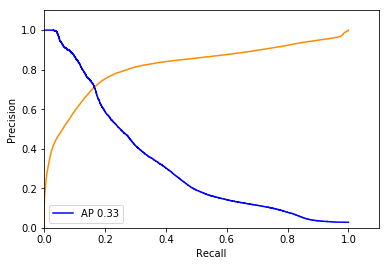

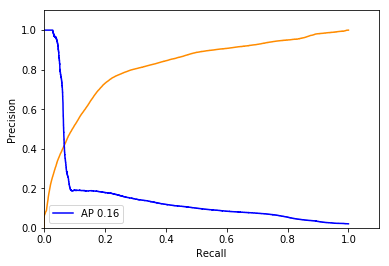

Failure detection on training videos:  0.20800000000000002 0.325 0.52 0.13
12 25 13
Failure detection on test videos:  0.1206896551724138 0.19886363636363638 0.35 0.07291666666666667
13 30 7


In [165]:

from sklearn.linear_model import LogisticRegression
model =  LogisticRegression(random_state=0)
model.fit(training_ds[:,1:],training_ds[:,0])

y = model.predict_proba(training_ds[:,1:])  
fpr, tpr, _ = roc_curve(training_ds[:,0], y[:,1])
plt.plot(fpr, tpr, color='darkorange')
precision, recall, _ = precision_recall_curve(training_ds[:,0], y[:,1])
plt.step(recall, precision, color='b',
         where='post', label='AP %0.2f' % average_precision_score(training_ds[:,0], y[:,1]))
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.show()

y = model.predict_proba(val_ds[:,1:])  
fpr, tpr, _ = roc_curve(val_ds[:,0], y[:,1])
plt.plot(fpr, tpr, color='darkorange')
precision, recall, _ = precision_recall_curve(val_ds[:,0], y[:,1])
plt.step(recall, precision, color='b',
         where='post', label='AP %0.2f' % average_precision_score(val_ds[:,0], y[:,1]))
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.show()

results = eval_vids(training_vids)
precision = len(results['tp'])/(len(results['fp'])+len(results['tp']))
recall = len(results['tp'])/(len(results['p']))
f1 = 2*(precision*recall)/(precision+recall)
f0_5 = (1+0.25)*(precision*recall)/(0.25*precision+recall)
print("Failure detection on training videos: ", f1, f0_5, precision, recall)
print(len(results['fp']), len(results['fn']), len(results['tp']))


results = eval_vids(val_vids)
precision = len(results['tp'])/(len(results['fp'])+len(results['tp']))
recall = len(results['tp'])/(len(results['p']))
f1 = 2*(precision*recall)/(precision+recall)
f0_5 = (1+0.25)*(precision*recall)/(0.25*precision+recall)
print("Failure detection on test videos: ", f1, f0_5, precision, recall)
print(len(results['fp']), len(results['fn']), len(results['tp']))


# Random Forest 

soft failure (`start1`) = 1
hard failure (`start2`) = 2


In [41]:
# feature_list = ['p1', 'p2', 'p3', 'rolling_ewm']
feature_list = ['p1', 'p2', 'p3', 'rolling_ewm', 'rolling_ewm_10', 'rolling_ewm_20', 'rolling_ewm_30', 'r10', 'r20', 'r30']


def load_detections(vid, thresh, ewm_span, rolling_win):

    df = pd.DataFrame(dets_map[vid], columns=['fid', 'p1', 'p2', 'p3'])
    df['accu_detection'] = df.p1.apply(clip, args=(thresh,)) + df.p2.apply(clip, args=(thresh,)) + df.p3.apply(clip, args=(thresh,))
    df['rolling_ewm'] = df.accu_detection.ewm(span=ewm_span).mean()
    df['rolling_ewm_10'] = 0
    df['rolling_ewm_20'] = 0
    df['rolling_ewm_30'] = 0
    df['r10'] = 0
    df['r30'] = 0
    df.loc[df.index[10:], 'rolling_ewm_10'] = df.loc[df.index[:-10], 'rolling_ewm'].to_numpy()
    df.loc[df.index[20:], 'rolling_ewm_20'] = df.loc[df.index[:-20], 'rolling_ewm'].to_numpy()
    df.loc[df.index[30:], 'rolling_ewm_30'] = df.loc[df.index[:-30], 'rolling_ewm'].to_numpy()
    df['r10'] = (df['rolling_ewm']/df['rolling_ewm_10'].clip(0.0001)).clip(0,10)
    df['r20'] = (df['rolling_ewm']/df['rolling_ewm_20'].clip(0.0001)).clip(0,10)
    df['r30'] = (df['rolling_ewm']/df['rolling_ewm_30'].clip(0.0001)).clip(0,10)

    return df.set_index('fid')


def load_as_xy(vid, clip_to_failure=False, thresh = 0.16, ewm_span = 9, rolling_win = 50, rolling_multiple = 5.43):
    df = load_detections(vid, thresh, ewm_span, rolling_win)
    start1 = int(failure_starts.loc[vid].start1)
    start2 = int(failure_starts.loc[vid].start2)
    if start2 >= MAX_FRAME_NUM:
        start2 = len(df)
    
    # give a bit of leeway for start1 since it is a very conservative point
    start1 = start1 + (start2 - start1)//5

#     df['has_failed'] = 0
#     df.loc[start1+5:, 'has_failed'] = 1
#     df.loc[start2+5:, 'has_failed'] = 2
    x = df[feature_list].to_numpy()

    y = np.zeros((len(df), 3))
    y[:start1, 0] = 1
    y[start1:start2, 1] = 1
    y[start2:, 2] = 1
    
    ds = np.concatenate([y[30:,:], x[30:,:]], axis=1)
    
    return ds
    # balance dataset
    y_zeros = ds[ds[:,0] < 1]
    y_nonzeros = ds[ds[:,0] >= 1]
    max_y_zeros = max(len(y_nonzeros), 2)
    
    np.random.shuffle(y_zeros)
    return np.vstack([y_nonzeros, y_zeros[:max_y_zeros,:]])
    


def detect_failure_start(vid, plot=False):
#     df = load_detections(vid, thresh = 0.16, ewm_span = 9, rolling_win = 50)
#     df['r'] = (df['rolling_ewm']/df['rolling_mean'].clip(0.0001)).clip(0,30)
    
#     has_failed = 0
#     has_failed_arr = np.array([])
#     failed_frame = None
    
#     for index, row in df.iterrows():
#         x = row[feature_list].to_numpy()
# #         x = np.append(x, [has_failed])
#         has_failed = model.predict(x.reshape(1, -1))[0]
#         if has_failed == 1 and failed_frame == None:
#             failed_frame = index
        
#         has_failed_arr = np.append(has_failed_arr, [has_failed])

#     if plot:
#         plt.plot(df.rolling_ewm)
#         plt.plot(has_failed_arr)
            
#     return failed_frame

    x = load_as_xy(vid, plot)
    if len(x) == 0:
        return None
    
    y = model.predict(x[:,3:])
    
    if plot:
        plt.plot(np.append(np.zeros(30), model.predict_proba(x[:,3:])[1][:,1]), color='b')
        plt.plot(np.append(np.zeros(30), model.predict_proba(x[:,3:])[2][:,1]), color='r')
        plt.plot(np.append(np.zeros(30), x[:,6]), color='g')

    if len(np.nonzero(y[:,1:])[0]) > 0:
        return np.nonzero(y[:,1:])[0][0] + 30

training_vids = np.hstack((failed_vids[:100], succeeded_vids[:1300]))
val_vids = np.hstack((failed_vids[100:], succeeded_vids[1300:]))

training_ds = np.vstack([load_as_xy(vid, False) for vid in training_vids])
np.random.shuffle(training_ds)
# val_ds = np.vstack([load_as_xy(vid, False) for vid in val_vids])


1. rolling_ewm_10 - (0.156698)
2. rolling_ewm - (0.136720)
3. r20 - (0.110835)
4. rolling_ewm_30 - (0.110189)
5. p3 - (0.101431)
6. rolling_ewm_20 - (0.098281)
7. p1 - (0.075330)
8. r10 - (0.074113)
9. r30 - (0.070089)
10. p2 - (0.066313)


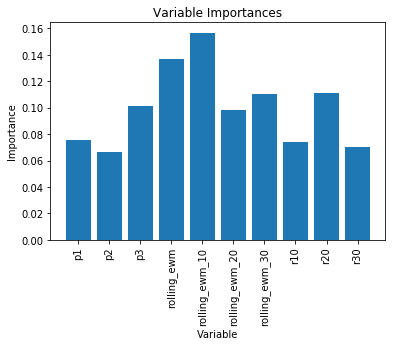

In [42]:

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state = 42, n_estimators=10, max_depth=15)
model.fit(training_ds[:,3:],training_ds[:,:3])

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
for f in range(training_ds[:,3:].shape[1]):
    print("%d. %s - (%f)" % (f + 1, feature_list[indices[f]], importances[indices[f]]))

# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [43]:

results_t = eval_vids(training_vids)
results = results_t
precision = len(results['tp'])/(len(results['fp'])+len(results['tp']))
recall = len(results['tp'])/(len(results['p']))
f1 = 2*(precision*recall)/(precision+recall)
f0_5 = (1+0.25)*(precision*recall)/(0.25*precision+recall)
print("Failure detection on test videos: F1: %0.2f - F0.5: %0.2f - Precision: %0.2f - Recall: %0.2f" % (f1, f0_5, precision, recall))
print("FP: {} - FN: {} - TP: {} - P: {}".format(len(results['fp']), len(results['fn']), len(results['tp']), len(results['p'])))

results_v = eval_vids(val_vids)
results = results_v
precision = len(results['tp'])/(len(results['fp'])+len(results['tp']))
recall = len(results['tp'])/(len(results['p']))
f1 = 2*(precision*recall)/(precision+recall)
f0_5 = (1+0.25)*(precision*recall)/(0.25*precision+recall)
print("Failure detection on test videos: F1: %0.2f - F0.5: %0.2f - Precision: %0.2f - Recall: %0.2f" % (f1, f0_5, precision, recall))
print("FP: {} - FN: {} - TP: {} - P: {}".format(len(results['fp']), len(results['fn']), len(results['tp']), len(results['p'])))

Failure detection on test videos: F1: 0.61 - F0.5: 0.73 - Precision: 0.84 - Recall: 0.48
FP: 9 - FN: 6 - TP: 48 - P: 100
Failure detection on test videos: F1: 0.27 - F0.5: 0.28 - Precision: 0.30 - Recall: 0.24
FP: 54 - FN: 25 - TP: 23 - P: 96


/Users/kenneth/.pyenv/versions/3.5.6/lib/python3.5/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/kenneth/.pyenv/versions/3.5.6/lib/python3.5/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/kenneth/.pyenv/versions/3.5.6/lib/python3.5/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pypl

{'fn': [],
 'fp': [],
 'p': [6221,
  6393,
  5947,
  10533,
  4595,
  5970,
  4637,
  11255,
  11271,
  10892,
  10771,
  5249,
  5241,
  5062,
  5890,
  5930,
  10442,
  11084,
  6223,
  10675,
  10862,
  10692,
  5553,
  6156,
  5808,
  10113,
  6194,
  6112,
  10432],
 'tn': [],
 'tp': [6221,
  6393,
  5947,
  10533,
  4595,
  5970,
  4637,
  11255,
  11271,
  10892,
  10771,
  5249,
  5241,
  5062,
  5890,
  5930,
  10442,
  11084,
  6223,
  10675,
  10862,
  10692,
  5553,
  6156,
  5808,
  10113,
  6194,
  6112,
  10432]}

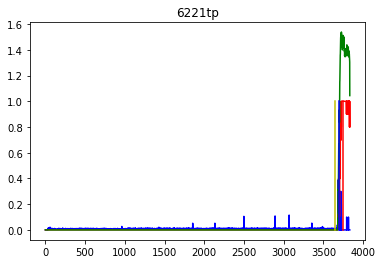

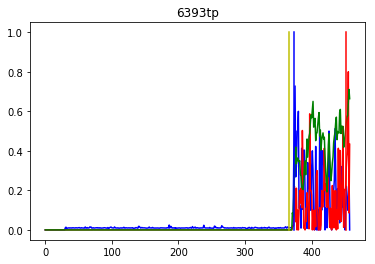

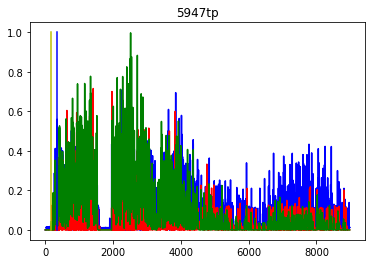

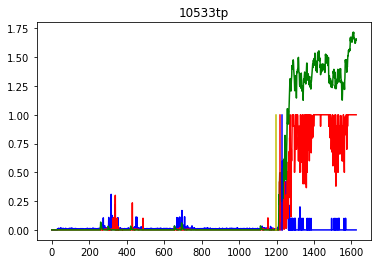

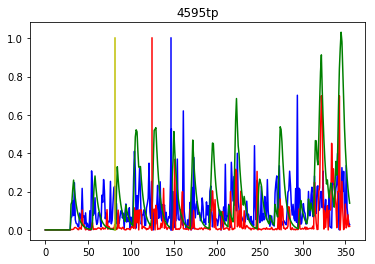

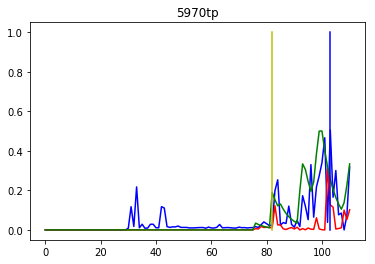

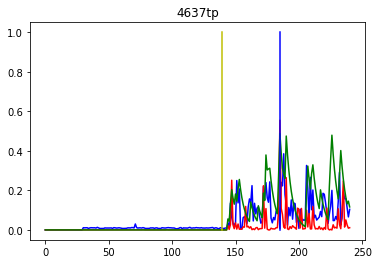

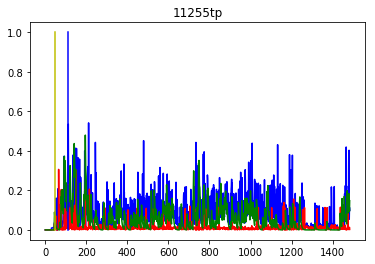

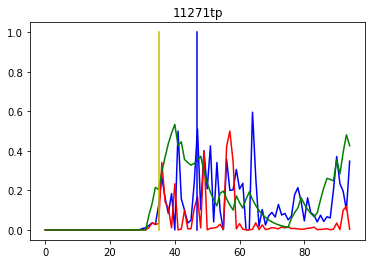

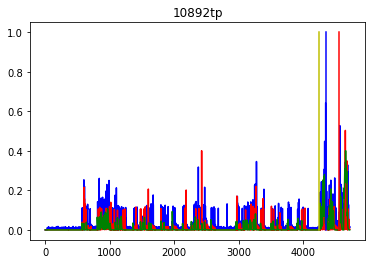

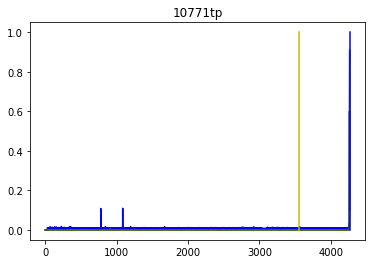

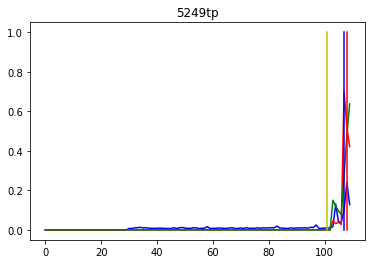

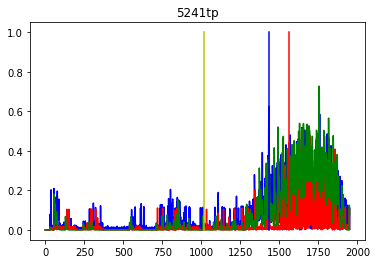

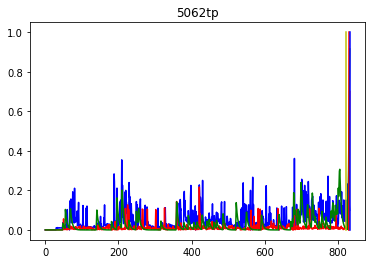

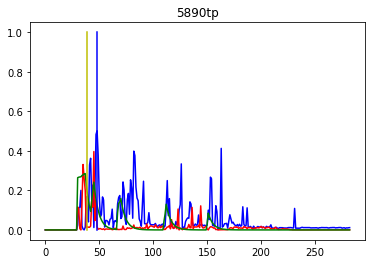

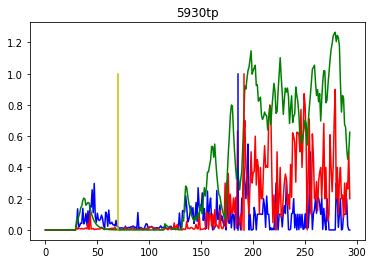

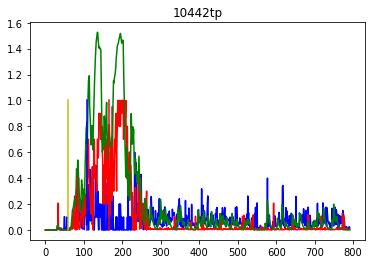

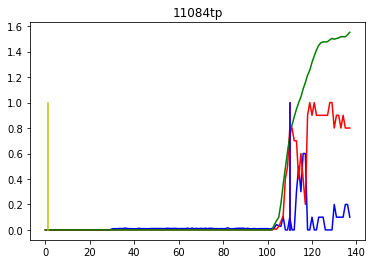

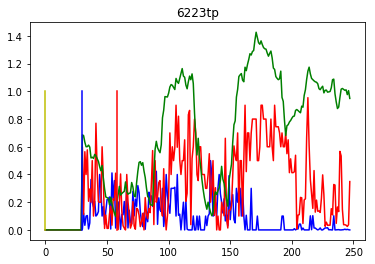

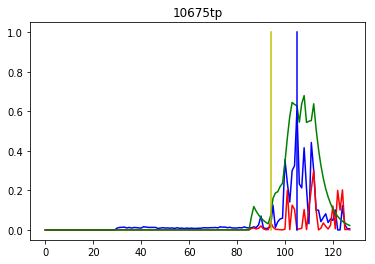

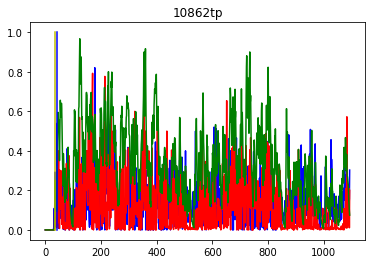

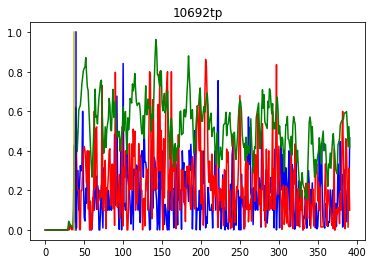

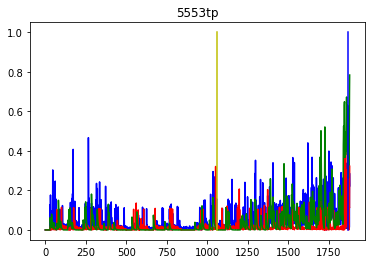

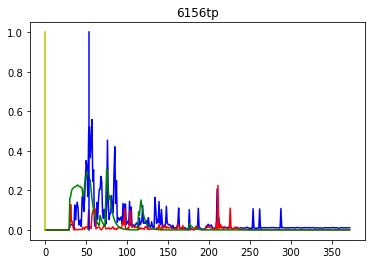

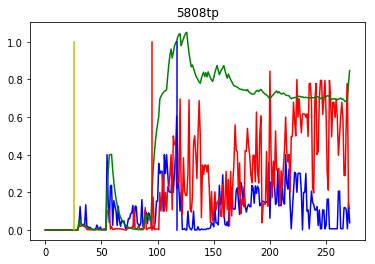

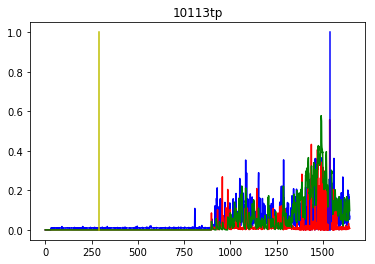

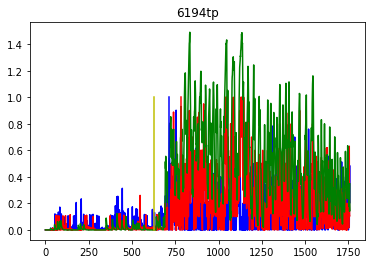

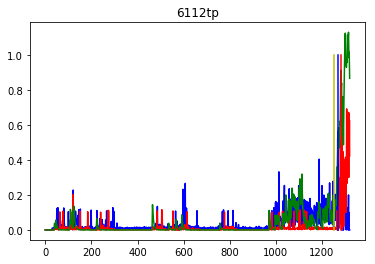

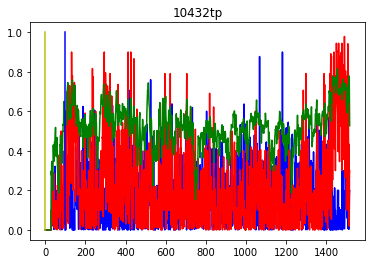

In [40]:
eval_vids(results_v['tp'], plot=True)

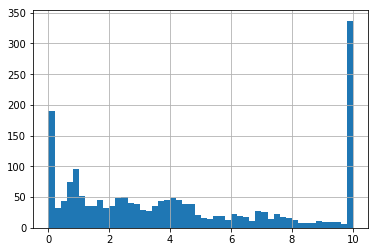

In [61]:
# good_df['r1'] = (good_df['rolling_ewm']/good_df['rolling_mean']).fillna(0).clip(0,10)
# good_df['r1'].hist(bins=50)
bad_df['r1'] = (bad_df['rolling_ewm']/bad_df['rolling_mean']).fillna(0).clip(0,10)
bad_df['r1'].hist(bins=50)
# ok_df['r1'] = (ok_df['rolling_ewm']/ok_df['rolling_mean']).fillna(0).clip(0,10)
# ok_df['r1'].hist(bins=50)

p1                0.249195
p2                0.143087
p3                0.094907
accu_detection    0.464675
rolling_ewm       0.401175
rolling_mean      0.140676
dtype: float64
p1                0.051069
p2                0.026682
p3                0.015408
accu_detection    0.243115
rolling_ewm       0.146625
rolling_mean      0.039075
dtype: float64
p1                0.091402
p2                0.042455
p3                0.026140
accu_detection    0.132129
rolling_ewm       0.104912
rolling_mean      0.068153
dtype: float64
p1                0.023180
p2                0.007343
p3                0.003422
accu_detection    0.079614
rolling_ewm       0.039488
rolling_mean      0.026788
dtype: float64
p1                0.023317
p2                0.010766
p3                0.006711
accu_detection    0.018861
rolling_ewm       0.018930
rolling_mean      0.022955
dtype: float64
p1                0.002753
p2                0.000570
p3                0.000175
accu_detection    0.006313
rolling

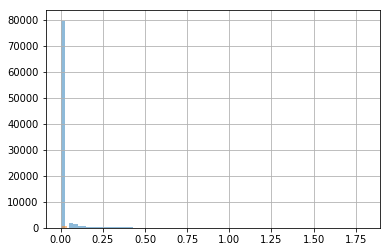

In [44]:
# bad_frames = []
# good_frames = []
# for vid in results['fp']:
#     start = detect_failure_start(vid, False)
#     df = load_detections(str(vid), thresh = 0.16, ewm_span = 9, rolling_win = 50, rolling_multiple = 5.43)
#     bad_frames += [df.loc[start:]]
#     good_frames += [df.loc[0:start]]
    
# bad_df_fp = reduce(lambda x, y: pd.concat([x,y], ignore_index=True), bad_frames)
# good_df_fp = reduce(lambda x, y: pd.concat([x,y], ignore_index=True), good_frames)

# print(bad_df_fp.mean())
# print(bad_df_fp.var())
# print(good_df_fp.mean())
# print(good_df_fp.var())


bad_frames = []
ok_frames = []
good_frames = []
ok_ratios = []
bad_ratios = []
for vid, video in failed_videos.iterrows():
    df = load_detections(str(vid), thresh = 0.06, ewm_span = 15, rolling_win = 460)
    ok_frames += [df.loc[video.start1:video.start1+20]]
    bad_frames += [df.loc[max(video.start1, video.start2-10):video.start2+20]]
    good_frames += [df.loc[50:video.start1]]
    ok_ratios += [good_frames[-1].p1.mean()/ok_frames[-1].p1.mean()]
    bad_ratios += [good_frames[-1].p1.mean()/bad_frames[-1].p1.mean()]
    
bad_df = reduce(lambda x, y: pd.concat([x,y], ignore_index=True), bad_frames)
ok_df = reduce(lambda x, y: pd.concat([x,y], ignore_index=True), ok_frames)
good_df = reduce(lambda x, y: pd.concat([x,y], ignore_index=True), good_frames)

succeeded_vids = [load_detections(str(i), thresh = 0.16, ewm_span = 9, rolling_win = 50) for i in failure_starts[failure_starts.start1 >= MAX_FRAME_NUM].index]
succeeded_frames = reduce(lambda x, y: pd.concat([x,y], ignore_index=True), succeeded_vids)

print(bad_df.mean())
print(bad_df.var())
print(ok_df.mean())
print(ok_df.var())
print(good_df.mean())
print(good_df.var())
print(succeeded_frames.mean())
print(succeeded_frames.var())
print(len(bad_df))
print(len(good_df))
print(len(succeeded_frames))
good_df.accu_detection.hist(bins=50, alpha=0.5)
bad_df.accu_detection.hist(bins=50, alpha=0.5)


In [31]:

def objective(x):
#     print(x)
#     hyper_vids = np.hstack((failed_videos.sample(40).index.values, succeeded_videos.sample(200).index.values))
    eval_res = eval_vids(vids, plot=False, thresh = x['thresh'], v_thresh = x['v_thresh'], min_ewm = x['min_ewm'], ewm_span = x['ewm_span'], rolling_win = x['rolling_win'], rolling_multiple = x['rolling_multiple'])
    eval_res['precision'] = len(eval_res['tp'])/max(len(eval_res['fp'])+len(eval_res['tp']),0.01)
    eval_res['recall'] = len(eval_res['tp'])/(len(eval_res['p']))
    eval_res['f1'] = 2*(eval_res['precision']*eval_res['recall'])/max(eval_res['precision']+eval_res['recall'], 0.01)
    eval_res['f0.5'] = (1+0.25)*(eval_res['precision']*eval_res['recall'])/max(0.25*eval_res['precision']+eval_res['recall'], 0.01)
    loss = 1 - eval_res['f0.5']
    print(loss)
    return {
        'loss': loss,
        'status': STATUS_OK,
        # -- store other results like this
        'eval_time': time.time(),
        'results': results,
        }

trials = Trials()

space = {
    'thresh': hp.quniform('thresh', 0.05, 0.6, 0.02),
    'v_thresh': hp.quniform('v_thresh', 1.5, 6, 0.1),
    'min_ewm': hp.quniform('min_ewm', 0.1, 1.5, 0.05),
    'ewm_span': hp.quniform('ewm_span', 2, 50, 1),
    'rolling_win': hp.quniform('rolling_win', 50, 500, 10),
    'rolling_multiple': hp.quniform('rolling_multiple', 1, 10, 0.2)
}
best = fmin(objective,
    space=space,
    algo=tpe.suggest,
    max_evals=2000,
    trials=trials)


1.0
0.9514563106796117
0.9299065420560748
0.8853211009174312
0.9752475247524752
0.6855345911949685
1.0
1.0
1.0
1.0
0.8200000000000001
0.6958855098389982
0.6345514950166112
0.9065420560747663
0.8260869565217391
0.6799307958477508
1.0
0.690923317683881
0.8695652173913043
0.6534653465346535
0.6244131455399061
0.654178674351585
0.5813953488372092
0.6502590673575129
0.6126760563380282
0.793233082706767
0.9514563106796117
0.6018276762402089
0.6568627450980392
0.6625222024866785
0.8760330578512396
0.6165644171779141
0.75177304964539
0.9285714285714286
0.88
0.5821727019498606
0.5935960591133005
1.0
0.6097560975609755
0.9285714285714286
0.7037037037037037
0.6186440677966102
0.574468085106383
1.0
0.6179039301310043
0.9285714285714286
0.9285714285714286
1.0
0.781021897810219
0.694616977225673
0.6756756756756757
0.7967479674796748
0.9285714285714286
0.674757281553398
0.708029197080292
0.6242774566473989
0.8672566371681416
0.9514563106796117
0.6914893617021277
0.8148148148148149
0.6568627450980392


KeyboardInterrupt: 

Text(0, 0.5, '$val$')

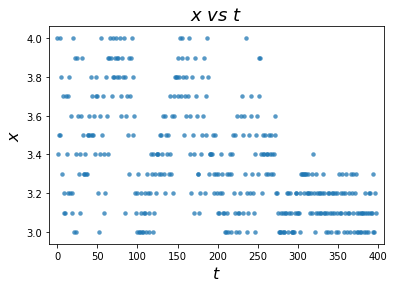

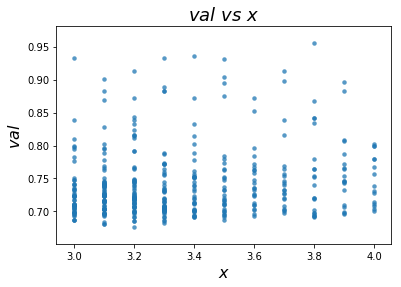

In [47]:
f, ax = plt.subplots(1)
xs = [t['tid'] for t in trials.trials[:-1]]
ys = [t['misc']['vals']['rolling_multiple'] for t in trials.trials[:-1]]
ax.set_xlim(xs[0]-10, xs[-1]+10)
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax.set_title('$x$ $vs$ $t$ ', fontsize=18)
ax.set_xlabel('$t$', fontsize=16)
ax.set_ylabel('$x$', fontsize=16)

f, ax = plt.subplots(1)
xs = [t['misc']['vals']['rolling_multiple'] for t in trials.trials[:-1]]
ys = [t['result']['loss'] for t in trials.trials[:-1]]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax.set_title('$val$ $vs$ $x$ ', fontsize=18)
ax.set_xlabel('$x$', fontsize=16)
ax.set_ylabel('$val$', fontsize=16)

In [32]:
tdf = pd.DataFrame([{**t['misc']['vals'], **dict(loss=[t['result']['loss']])} for t in trials.trials[:-1]])
tdf = tdf.applymap(lambda x: x[0])
tdf[tdf.loss < 63 ].corr()
# tdf.corr()
# rolling_multiple = 3-4
# rolling_win > 150
# min_ewm > 0.3
# ewm_span 12 - 20
# v_thresh > 1.5
# thresh 0.05 - 0.3
tdf.sort_values(by=['loss']).head(50)

ewm_span      loss  min_ewm  rolling_multiple  rolling_win  thresh  \
159      12.0  0.566667     0.55               6.0        400.0    0.10   
148      10.0  0.572864     0.65               6.6        350.0    0.12   
158       8.0  0.573171     0.70               6.0        360.0    0.10   
42       19.0  0.574468     0.35               2.8         80.0    0.38   
149      10.0  0.576271     0.65               7.0        350.0    0.06   
150       7.0  0.577114     0.75               6.4        350.0    0.10   
169      12.0  0.577626     0.50               7.2        370.0    0.14   
22       10.0  0.581395     0.80               1.2        500.0    0.30   
35       16.0  0.582173     0.50               2.6        350.0    0.16   
189       9.0  0.584746     0.50               5.8        300.0    0.18   
227      10.0  0.588477     0.70               3.8        390.0    0.06   
151       7.0  0.589744     0.75               6.4        390.0    0.06   
185      18.0  0.590909     0.65               5.4        340.0    0.06   
231       5.0  0.592275     0.75               5.8        200.0    0.08   
36       16.0  0.593596     0.45               6.8        350.0    0.22   
176       9.0  0.595142     0.50               9.0        470.0    0.20   
139      22.0  0.595960     0.45               3.0        410.0    0.20   
188      25.0  0.596413     0.40               5.0        390.0    0.10   
99       26.0  0.597156     0.50               4.6        460.0    0.14   
172       8.0  0.597701     0.55               7.8        400.0    0.18   
166      11.0  0.598854     0.40               6.2        320.0    0.16   
154       4.0  0.599738     0.65               7.2        330.0    0.12   
65       16.0  0.600977     0.50               3.4        340.0    0.10   
27        7.0  0.601828     0.70               2.4        460.0    0.06   
98       13.0  0.602122     0.40               4.2        230.0    0.16   
160      12.0  0.602473     0.45               5.8        380.0    0.18   
104      17.0  0.603321     0.45               3.0        440.0    0.34   
69       27.0  0.604478     0.45               1.8        370.0    0.22   
162      15.0  0.604520     0.60               6.6        450.0    0.12   
132       5.0  0.605678     0.85               2.2        250.0    0.10   
203       5.0  0.606017     0.60               7.0        380.0    0.20   
136       9.0  0.608295     0.70               1.8        150.0    0.36   
155      10.0  0.608939     0.60               8.4        350.0    0.06   
206      17.0  0.609053     0.40               5.4        370.0    0.28   
142      26.0  0.609121     0.40               1.6        170.0    0.32   
38       23.0  0.609756     0.45               4.0        180.0    0.18   
163       8.0  0.610592     0.55               5.2        390.0    0.16   
72       11.0  0.610592     0.50               2.0        350.0    0.32   
209       4.0  0.612211     0.80               4.6        320.0    0.18   
24       11.0  0.612676     0.80               2.0        370.0    0.28   
81       32.0  0.613900     0.40               1.4        390.0    0.34   
164      13.0  0.614148     0.45               5.6        460.0    0.12   
105      24.0  0.614537     0.55               1.4        380.0    0.32   
77        6.0  0.615385     0.70               2.4        410.0    0.40   
137      29.0  0.615385     0.35               3.4        200.0    0.38   
70        8.0  0.615385     0.70               1.2        270.0    0.16   
161      14.0  0.615385     0.70               6.0        400.0    0.14   
80        9.0  0.615385     0.75               4.0        260.0    0.36   
145      13.0  0.616041     0.35               7.6        320.0    0.22   
95        6.0  0.616438     0.65               2.2        130.0    0.24   

     v_thresh  
159       1.9  
148       3.4  
158       1.9  
42        5.7  
149       1.7  
150       1.7  
169       2.5  
22        1.5  
35        4.8  
189       2.3  
227

In [33]:
# Hyperparameter grid search

# thresh_arr = np.linspace(0.05, 0.3, 3)
# v_thresh_arr = np.linspace(1.5, 3, 2)
# min_ewm_arr = np.linspace(0.3, 0.7, 3)
# ewm_span_arr = np.linspace(2, 30, 3)
rolling_win_arr = np.linspace(10, 510, 21)
# rolling_multiple_arr = np.linspace(3, 4, 2)
# ewm_factor_arr = np.linspace(1, 4, 3)
# multiple_factor_arr = np.linspace(1, 4, 3)

loss_arr = []
# for r in np.array(np.meshgrid(thresh_arr, v_thresh_arr, min_ewm_arr, ewm_span_arr, rolling_win_arr, rolling_multiple_arr, ewm_factor_arr, multiple_factor_arr)).T.reshape(-1,8):
#     loss_arr += [objective(dict(thresh=r[0], v_thresh=r[1], min_ewm=r[2], ewm_span=r[3], rolling_win=r[4], rolling_multiple=r[5], ewm_factor=r[6], multiple_factor=r[7]))]
for w in rolling_win_arr:
    loss_arr += [dict(loss=objective(dict(v_thresh=2.4000000000000004, rolling_multiple=2.2, ewm_span=15.0, min_ewm=0.65, thresh=0.06, rolling_win=w)), rolling_win=w)]


1.0
0.703125
0.5595238095238095
0.5200892857142858
0.5085470085470085
0.5127118644067796
0.5144628099173554
0.5223577235772359
0.5161290322580645
0.5161290322580645
0.5161290322580645
0.51
0.5138888888888888
0.5138888888888888
0.51
0.5138888888888888
0.5177165354330708
0.5177165354330708
0.5177165354330708
0.5177165354330708
0.5177165354330708


In [49]:
tdf = pd.DataFrame([dict(loss=l['loss']['loss'], rolling_win=l['rolling_win']) for l in loss_arr])
tdf = tdf.set_index('rolling_win')
tdf.sort_values(by=['loss']).head(50)

loss
rolling_win          
110.0        0.508547
360.0        0.510000
285.0        0.510000
135.0        0.512712
385.0        0.513889
310.0        0.513889
335.0        0.513889
160.0        0.514463
260.0        0.516129
210.0        0.516129
235.0        0.516129
460.0        0.517717
435.0        0.517717
410.0        0.517717
510.0        0.517717
485.0        0.517717
85.0         0.520089
185.0        0.522358
60.0         0.559524
35.0         0.703125
10.0         1.000000